In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-20 03:43:15,307] A new study created in memory with name: no-name-2f704cc9-5f9d-4a8e-934c-c9643fe72755
[I 2025-05-20 03:47:37,217] Trial 0 finished with value: 0.5838303744792939 and parameters: {'lr': 0.03482209524568337, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.44275832245846247}. Best is trial 0 with value: 0.5838303744792939.


Cross Validation Accuracies:
[0.24117211997509003, 0.9811906814575195, 0.8703746199607849, 0.22993110120296478, 0.5964833498001099]
Mean Cross Validation Accuracy:
0.5838303744792939
Standard Deviation of Cross Validation Accuracy:
0.31074822315509304


[I 2025-05-20 03:54:27,007] Trial 1 finished with value: 0.043068673461675644 and parameters: {'lr': 0.0023222537858946213, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2415277815213711}. Best is trial 1 with value: 0.043068673461675644.


Cross Validation Accuracies:
[0.035915981978178024, 0.03389706090092659, 0.06218894571065903, 0.04393520951271057, 0.03940616920590401]
Mean Cross Validation Accuracy:
0.043068673461675644
Standard Deviation of Cross Validation Accuracy:
0.010149178345552136


[I 2025-05-20 04:03:07,999] Trial 2 finished with value: 1.2794969201087951 and parameters: {'lr': 0.15364299898366734, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.35279653647586684}. Best is trial 1 with value: 0.043068673461675644.


Cross Validation Accuracies:
[1.5784282684326172, 1.3466072082519531, 1.0180944204330444, 0.8455992341041565, 1.6087554693222046]
Mean Cross Validation Accuracy:
1.2794969201087951
Standard Deviation of Cross Validation Accuracy:
0.30294336195810134


[I 2025-05-20 04:12:34,921] Trial 3 finished with value: 0.04092843048274517 and parameters: {'lr': 0.00474183645767456, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4262859125704196}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[0.05812413617968559, 0.03259233385324478, 0.02974620647728443, 0.040767986327409744, 0.0434114895761013]
Mean Cross Validation Accuracy:
0.04092843048274517
Standard Deviation of Cross Validation Accuracy:
0.009964098152151447


[I 2025-05-20 04:18:58,677] Trial 4 finished with value: 0.07643059939146042 and parameters: {'lr': 0.0029870932111191045, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.455845258400985}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[0.026130951941013336, 0.05444972217082977, 0.11356692761182785, 0.07741813361644745, 0.11058726161718369]
Mean Cross Validation Accuracy:
0.07643059939146042
Standard Deviation of Cross Validation Accuracy:
0.03334658354004571


[I 2025-05-20 04:28:09,688] Trial 5 finished with value: 3.085902786254883 and parameters: {'lr': 0.07119530630782037, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24790200254358702}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[3.9382896423339844, 3.4495351314544678, 1.5675530433654785, 3.4484031200408936, 3.02573299407959]
Mean Cross Validation Accuracy:
3.085902786254883
Standard Deviation of Cross Validation Accuracy:
0.8123059365176981


[I 2025-05-20 04:34:03,603] Trial 6 finished with value: 0.04608792513608932 and parameters: {'lr': 0.05458941451977971, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.46479236770992705}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[0.025545360520482063, 0.08136358857154846, 0.03542647883296013, 0.059260960668325424, 0.028843237087130547]
Mean Cross Validation Accuracy:
0.04608792513608932
Standard Deviation of Cross Validation Accuracy:
0.021217652839615186


[I 2025-05-20 04:42:31,798] Trial 7 finished with value: 0.05056253485381603 and parameters: {'lr': 0.011839850956887365, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10132945684071451}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[0.037648335099220276, 0.03722459822893143, 0.0852663591504097, 0.062092188745737076, 0.030581193044781685]
Mean Cross Validation Accuracy:
0.05056253485381603
Standard Deviation of Cross Validation Accuracy:
0.020402056116366498


[I 2025-05-20 04:49:42,812] Trial 8 finished with value: 18.369715785980226 and parameters: {'lr': 0.5618142526175064, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3971369633046936}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[32.843772888183594, 5.24626350402832, 16.4434814453125, 34.37224578857422, 2.9428153038024902]
Mean Cross Validation Accuracy:
18.369715785980226
Standard Deviation of Cross Validation Accuracy:
13.262759384838562


[I 2025-05-20 04:55:41,266] Trial 9 finished with value: 0.08777802065014839 and parameters: {'lr': 0.0011299655723679776, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26889184176322967}. Best is trial 3 with value: 0.04092843048274517.


Cross Validation Accuracies:
[0.12921467423439026, 0.1258261799812317, 0.058070555329322815, 0.0636754184961319, 0.0621032752096653]
Mean Cross Validation Accuracy:
0.08777802065014839
Standard Deviation of Cross Validation Accuracy:
0.03251867207793217


[I 2025-05-20 05:01:52,217] Trial 10 finished with value: 0.03850569613277912 and parameters: {'lr': 0.010448262510569678, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34220152660058534}. Best is trial 10 with value: 0.03850569613277912.


Cross Validation Accuracies:
[0.026853470131754875, 0.060853030532598495, 0.029744498431682587, 0.0452813059091568, 0.02979617565870285]
Mean Cross Validation Accuracy:
0.03850569613277912
Standard Deviation of Cross Validation Accuracy:
0.012912791684559104


[I 2025-05-20 05:07:31,383] Trial 11 finished with value: 0.035621512308716775 and parameters: {'lr': 0.009243464700124819, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35752499510499375}. Best is trial 11 with value: 0.035621512308716775.


Cross Validation Accuracies:
[0.035204414278268814, 0.029134826734662056, 0.03496033325791359, 0.0517461858689785, 0.02706180140376091]
Mean Cross Validation Accuracy:
0.035621512308716775
Standard Deviation of Cross Validation Accuracy:
0.00867135475508064


[I 2025-05-20 05:13:11,644] Trial 12 finished with value: 0.0346340149641037 and parameters: {'lr': 0.012051628723684796, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33634063393830427}. Best is trial 12 with value: 0.0346340149641037.


Cross Validation Accuracies:
[0.026938414201140404, 0.033497098833322525, 0.029880939051508904, 0.04176672548055649, 0.04108689725399017]
Mean Cross Validation Accuracy:
0.0346340149641037
Standard Deviation of Cross Validation Accuracy:
0.00592658129415074


[I 2025-05-20 05:18:50,948] Trial 13 finished with value: 0.03567123524844647 and parameters: {'lr': 0.012576638083449455, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17081513157140435}. Best is trial 12 with value: 0.0346340149641037.


Cross Validation Accuracies:
[0.025608938187360764, 0.02698962204158306, 0.02978237345814705, 0.048424091190099716, 0.04755115136504173]
Mean Cross Validation Accuracy:
0.03567123524844647
Standard Deviation of Cross Validation Accuracy:
0.01014954841173013


[I 2025-05-20 05:24:03,865] Trial 14 finished with value: 0.034242911264300346 and parameters: {'lr': 0.018625532435802263, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3268612934592973}. Best is trial 14 with value: 0.034242911264300346.


Cross Validation Accuracies:
[0.037669841200113297, 0.029909448698163033, 0.029939819127321243, 0.041095372289419174, 0.032600075006484985]
Mean Cross Validation Accuracy:
0.034242911264300346
Standard Deviation of Cross Validation Accuracy:
0.00444284777158032


[I 2025-05-20 05:30:13,766] Trial 15 finished with value: 0.06792715787887574 and parameters: {'lr': 0.12244343452344181, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3096966719676144}. Best is trial 14 with value: 0.034242911264300346.


Cross Validation Accuracies:
[0.0632782131433487, 0.050322290509939194, 0.08030306547880173, 0.08624206483364105, 0.059490155428647995]
Mean Cross Validation Accuracy:
0.06792715787887574
Standard Deviation of Cross Validation Accuracy:
0.013351598842540148


[I 2025-05-20 05:36:51,642] Trial 16 finished with value: 0.04071599468588829 and parameters: {'lr': 0.017225425592003605, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.20159920229613496}. Best is trial 14 with value: 0.034242911264300346.


Cross Validation Accuracies:
[0.03214747831225395, 0.06004270538687706, 0.03495318815112114, 0.04399876296520233, 0.03243783861398697]
Mean Cross Validation Accuracy:
0.04071599468588829
Standard Deviation of Cross Validation Accuracy:
0.010577859840710083


[I 2025-05-20 05:42:35,090] Trial 17 finished with value: 0.03423457704484463 and parameters: {'lr': 0.023886438078947657, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4977762780629781}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.028511274605989456, 0.03256424143910408, 0.029733208939433098, 0.05009837448596954, 0.03026578575372696]
Mean Cross Validation Accuracy:
0.03423457704484463
Standard Deviation of Cross Validation Accuracy:
0.008040148011427642


[I 2025-05-20 05:50:03,102] Trial 18 finished with value: 0.17978196442127228 and parameters: {'lr': 0.36088592617912285, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.402983223414051}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.19370727241039276, 0.16132286190986633, 0.16510356962680817, 0.193584144115448, 0.18519197404384613]
Mean Cross Validation Accuracy:
0.17978196442127228
Standard Deviation of Cross Validation Accuracy:
0.01392750020848871


[I 2025-05-20 05:56:22,448] Trial 19 finished with value: 0.12511565834283828 and parameters: {'lr': 0.21724360386866, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48222699794623236}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.1332526057958603, 0.12773308157920837, 0.1371823102235794, 0.12425524741411209, 0.10315504670143127]
Mean Cross Validation Accuracy:
0.12511565834283828
Standard Deviation of Cross Validation Accuracy:
0.011846296269243795


[I 2025-05-20 06:03:33,816] Trial 20 finished with value: 0.523148101568222 and parameters: {'lr': 0.02302097489204579, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11273807655887638}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.5568717122077942, 0.3972395956516266, 0.5565457940101624, 0.5850048661231995, 0.5200785398483276]
Mean Cross Validation Accuracy:
0.523148101568222
Standard Deviation of Cross Validation Accuracy:
0.06624397507325085


[I 2025-05-20 06:08:42,881] Trial 21 finished with value: 0.06261827424168587 and parameters: {'lr': 0.005718681323805038, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49869065267435797}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.028916388750076294, 0.13071469962596893, 0.05264052376151085, 0.07324375957250595, 0.02757599949836731]
Mean Cross Validation Accuracy:
0.06261827424168587
Standard Deviation of Cross Validation Accuracy:
0.03798251623616614


[I 2025-05-20 06:14:03,970] Trial 22 finished with value: 0.0419752549380064 and parameters: {'lr': 0.03779303618836768, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2963518221952694}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.06966334581375122, 0.028878934681415558, 0.03072323091328144, 0.04087178036570549, 0.039738982915878296]
Mean Cross Validation Accuracy:
0.0419752549380064
Standard Deviation of Cross Validation Accuracy:
0.014635372178037363


[I 2025-05-20 06:19:33,822] Trial 23 finished with value: 0.05146991871297359 and parameters: {'lr': 0.07004341811711794, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3841016221856332}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.050711438059806824, 0.0252156313508749, 0.06732954829931259, 0.061894599348306656, 0.052198376506567]
Mean Cross Validation Accuracy:
0.05146991871297359
Standard Deviation of Cross Validation Accuracy:
0.014495484576339613


[I 2025-05-20 06:23:57,423] Trial 24 finished with value: 0.04432580657303333 and parameters: {'lr': 0.02400612469798434, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31461827075376436}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.02542097680270672, 0.08892505615949631, 0.03160722553730011, 0.0466972254216671, 0.02897854894399643]
Mean Cross Validation Accuracy:
0.04432580657303333
Standard Deviation of Cross Validation Accuracy:
0.023449562469141486


[I 2025-05-20 06:29:33,164] Trial 25 finished with value: 0.03627886176109314 and parameters: {'lr': 0.0061835986041992065, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2055076212367503}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.026018507778644562, 0.022591620683670044, 0.03323286399245262, 0.042463693767786026, 0.057087622582912445]
Mean Cross Validation Accuracy:
0.03627886176109314
Standard Deviation of Cross Validation Accuracy:
0.012435032838347508


[I 2025-05-20 06:34:30,471] Trial 26 finished with value: 0.0375905342400074 and parameters: {'lr': 0.019911146976212112, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3758817111909984}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.025423169136047363, 0.043482452630996704, 0.030661217868328094, 0.0438321977853775, 0.04455363377928734]
Mean Cross Validation Accuracy:
0.0375905342400074
Standard Deviation of Cross Validation Accuracy:
0.007977694156653135


[I 2025-05-20 06:39:13,029] Trial 27 finished with value: 0.11023325771093369 and parameters: {'lr': 0.002881608076387554, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4230743177921864}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.03695090860128403, 0.12405422329902649, 0.10776112228631973, 0.19604136049747467, 0.08635867387056351]
Mean Cross Validation Accuracy:
0.11023325771093369
Standard Deviation of Cross Validation Accuracy:
0.05196240851182688


[I 2025-05-20 06:44:07,874] Trial 28 finished with value: 0.04153831526637077 and parameters: {'lr': 0.04445367241701908, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27903663947512264}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.025426216423511505, 0.04268471151590347, 0.05411706864833832, 0.05144885554909706, 0.03401472419500351]
Mean Cross Validation Accuracy:
0.04153831526637077
Standard Deviation of Cross Validation Accuracy:
0.010714123589282207


[I 2025-05-20 06:49:14,459] Trial 29 finished with value: 0.10021772682666778 and parameters: {'lr': 0.030987556221257838, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3310593363668853}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.10085632652044296, 0.07121021300554276, 0.14009623229503632, 0.10921380668878555, 0.07971205562353134]
Mean Cross Validation Accuracy:
0.10021772682666778
Standard Deviation of Cross Validation Accuracy:
0.024222100942812904


[I 2025-05-20 06:54:14,643] Trial 30 finished with value: 2.8458824157714844 and parameters: {'lr': 0.10692047590801729, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.42576164537504907}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[4.7384257316589355, 4.111453533172607, 3.7183737754821777, 0.36882102489471436, 1.2923380136489868]
Mean Cross Validation Accuracy:
2.8458824157714844
Standard Deviation of Cross Validation Accuracy:
1.7025842106643958


[I 2025-05-20 06:58:58,385] Trial 31 finished with value: 0.04192739352583885 and parameters: {'lr': 0.008101362329079487, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.36193632805156845}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.0324554517865181, 0.02804049849510193, 0.06759470701217651, 0.04224773496389389, 0.03929857537150383]
Mean Cross Validation Accuracy:
0.04192739352583885
Standard Deviation of Cross Validation Accuracy:
0.013772347795777018


[I 2025-05-20 07:03:31,946] Trial 32 finished with value: 0.036473529413342476 and parameters: {'lr': 0.013857548940215228, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3291921759303967}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.03176453709602356, 0.03906611353158951, 0.0419740304350853, 0.0407756045460701, 0.028787361457943916]
Mean Cross Validation Accuracy:
0.036473529413342476
Standard Deviation of Cross Validation Accuracy:
0.005229467292778074


[I 2025-05-20 07:07:44,720] Trial 33 finished with value: 0.058423202484846115 and parameters: {'lr': 0.0041469170158778546, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3642251737205082}. Best is trial 17 with value: 0.03423457704484463.


Cross Validation Accuracies:
[0.02763477712869644, 0.08279433846473694, 0.09931283444166183, 0.04666256532073021, 0.03571149706840515]
Mean Cross Validation Accuracy:
0.058423202484846115
Standard Deviation of Cross Validation Accuracy:
0.02781357782039036


[I 2025-05-20 07:11:43,051] Trial 34 finished with value: 0.032134828716516496 and parameters: {'lr': 0.008241120229243164, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27985690162184557}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.030709607526659966, 0.023517968133091927, 0.03152475878596306, 0.04305562376976013, 0.03186618536710739]
Mean Cross Validation Accuracy:
0.032134828716516496
Standard Deviation of Cross Validation Accuracy:
0.00626082519989961


[I 2025-05-20 07:15:22,912] Trial 35 finished with value: 0.05270120948553085 and parameters: {'lr': 0.0019234768192296467, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2356089567575835}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.08045559376478195, 0.04959478601813316, 0.03529713302850723, 0.0674293115735054, 0.030729223042726517]
Mean Cross Validation Accuracy:
0.05270120948553085
Standard Deviation of Cross Validation Accuracy:
0.01888143410950366


[I 2025-05-20 07:22:17,989] Trial 36 finished with value: 0.2289566606283188 and parameters: {'lr': 0.008138491821473788, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26346835547646347}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.25790300965309143, 0.2091384083032608, 0.21537154912948608, 0.23245681822299957, 0.22991351783275604]
Mean Cross Validation Accuracy:
0.2289566606283188
Standard Deviation of Cross Validation Accuracy:
0.016901929951438233


[I 2025-05-20 07:26:45,780] Trial 37 finished with value: 0.04349654093384743 and parameters: {'lr': 0.03230663586673184, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.28485467903104095}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.05759783834218979, 0.02183695137500763, 0.07028571516275406, 0.04071981832385063, 0.027042381465435028]
Mean Cross Validation Accuracy:
0.04349654093384743
Standard Deviation of Cross Validation Accuracy:
0.01824332106052762


[I 2025-05-20 07:31:54,843] Trial 38 finished with value: 0.03899579904973507 and parameters: {'lr': 0.004494960106894059, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2239335025798804}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.028850875794887543, 0.052228715270757675, 0.04451374709606171, 0.04258519783616066, 0.026800459250807762]
Mean Cross Validation Accuracy:
0.03899579904973507
Standard Deviation of Cross Validation Accuracy:
0.009696260997524799


[I 2025-05-20 07:39:38,545] Trial 39 finished with value: 0.9659879326820373 and parameters: {'lr': 0.015848951732264544, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1578977425664003}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.7861219048500061, 0.8085768222808838, 0.8401168584823608, 1.1272780895233154, 1.2678459882736206]
Mean Cross Validation Accuracy:
0.9659879326820373
Standard Deviation of Cross Validation Accuracy:
0.1949904476559778


[I 2025-05-20 07:45:18,211] Trial 40 finished with value: 0.03240546993911266 and parameters: {'lr': 0.02613462784176618, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24935824151066943}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.026470905169844627, 0.02226266823709011, 0.030074667185544968, 0.05642601475119591, 0.026793094351887703]
Mean Cross Validation Accuracy:
0.03240546993911266
Standard Deviation of Cross Validation Accuracy:
0.012263877524213993


[I 2025-05-20 07:51:34,911] Trial 41 finished with value: 0.04993084445595741 and parameters: {'lr': 0.05724224365970212, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2635375555807346}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.04126010462641716, 0.05418166145682335, 0.0640304684638977, 0.05634256824851036, 0.03383941948413849]
Mean Cross Validation Accuracy:
0.04993084445595741
Standard Deviation of Cross Validation Accuracy:
0.010882046968722199


[I 2025-05-20 07:57:46,038] Trial 42 finished with value: 0.03740636482834816 and parameters: {'lr': 0.02505938941298983, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24624599833830216}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.02755899541079998, 0.048887576907873154, 0.03973636403679848, 0.04068223759531975, 0.03016665019094944]
Mean Cross Validation Accuracy:
0.03740636482834816
Standard Deviation of Cross Validation Accuracy:
0.0077118431258477275


[I 2025-05-20 08:02:20,654] Trial 43 finished with value: 0.033662088215351105 and parameters: {'lr': 0.007723729171547155, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3002153134228929}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.030642511323094368, 0.029372746124863625, 0.03768300637602806, 0.04194337874650955, 0.028668798506259918]
Mean Cross Validation Accuracy:
0.033662088215351105
Standard Deviation of Cross Validation Accuracy:
0.005238259214905475


[I 2025-05-20 08:09:53,318] Trial 44 finished with value: 0.0416305173188448 and parameters: {'lr': 0.00804863607945691, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21530792022192596}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.0309035312384367, 0.03757695108652115, 0.06516960263252258, 0.04066741466522217, 0.03383508697152138]
Mean Cross Validation Accuracy:
0.0416305173188448
Standard Deviation of Cross Validation Accuracy:
0.012225256381729511


[I 2025-05-20 08:14:10,336] Trial 45 finished with value: 0.11869008988142013 and parameters: {'lr': 0.0035973421944020065, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.29821144368655234}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.13234052062034607, 0.11315727978944778, 0.0945870578289032, 0.12932169437408447, 0.12404389679431915]
Mean Cross Validation Accuracy:
0.11869008988142013
Standard Deviation of Cross Validation Accuracy:
0.013708367251760873


[I 2025-05-20 08:19:06,590] Trial 46 finished with value: 0.036412594467401506 and parameters: {'lr': 0.006266078451356439, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.255570542444367}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.026093922555446625, 0.04293181002140045, 0.03034060075879097, 0.05392579734325409, 0.028770841658115387]
Mean Cross Validation Accuracy:
0.036412594467401506
Standard Deviation of Cross Validation Accuracy:
0.01049717038094055


[I 2025-05-20 08:23:48,732] Trial 47 finished with value: 0.09398209676146507 and parameters: {'lr': 0.001831012927260932, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4443152837236932}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.03066238760948181, 0.1798228621482849, 0.11758751422166824, 0.045409876853227615, 0.09642784297466278]
Mean Cross Validation Accuracy:
0.09398209676146507
Standard Deviation of Cross Validation Accuracy:
0.05347986635007761


[I 2025-05-20 08:28:09,036] Trial 48 finished with value: 1.2505802631378173 and parameters: {'lr': 0.01599808287004209, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17700813460634332}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[1.2810014486312866, 1.2716257572174072, 1.2645175457000732, 1.115257978439331, 1.3204985857009888]
Mean Cross Validation Accuracy:
1.2505802631378173
Standard Deviation of Cross Validation Accuracy:
0.0703751401549839


[I 2025-05-20 08:32:06,502] Trial 49 finished with value: 0.03741095475852489 and parameters: {'lr': 0.01085524231875381, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3182479850401527}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.032618775963783264, 0.05217675119638443, 0.03156602755188942, 0.04174543172121048, 0.02894778735935688]
Mean Cross Validation Accuracy:
0.03741095475852489
Standard Deviation of Cross Validation Accuracy:
0.00855067002125958


[I 2025-05-20 08:41:48,176] Trial 50 finished with value: 0.44040889739990235 and parameters: {'lr': 0.8793890446264435, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27721208726997887}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.43571460247039795, 0.4304198920726776, 0.42379215359687805, 0.45681989192962646, 0.45529794692993164]
Mean Cross Validation Accuracy:
0.44040889739990235
Standard Deviation of Cross Validation Accuracy:
0.013333696743890207


[I 2025-05-20 08:47:30,000] Trial 51 finished with value: 0.077904162555933 and parameters: {'lr': 0.029177758278553678, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3416711216795952}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.17157170176506042, 0.08453778922557831, 0.05792725458741188, 0.0450780913233757, 0.030405975878238678]
Mean Cross Validation Accuracy:
0.077904162555933
Standard Deviation of Cross Validation Accuracy:
0.050100535818496876


[I 2025-05-20 08:53:29,380] Trial 52 finished with value: 0.037509098276495935 and parameters: {'lr': 0.010825012167768763, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28975306005538326}. Best is trial 34 with value: 0.032134828716516496.


Cross Validation Accuracies:
[0.02719733864068985, 0.021315624937415123, 0.04041527211666107, 0.06671149283647537, 0.03190576285123825]
Mean Cross Validation Accuracy:
0.037509098276495935
Standard Deviation of Cross Validation Accuracy:
0.015881964789559794


[I 2025-05-20 08:59:04,893] Trial 53 finished with value: 0.030594317615032195 and parameters: {'lr': 0.019449092862914984, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23370177435498146}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.027012484148144722, 0.024036236107349396, 0.030186600983142853, 0.04073764756321907, 0.03099861927330494]
Mean Cross Validation Accuracy:
0.030594317615032195
Standard Deviation of Cross Validation Accuracy:
0.005640120551309383


[I 2025-05-20 09:03:48,212] Trial 54 finished with value: 0.03230604901909828 and parameters: {'lr': 0.019435250266149444, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18399602882638488}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025505661964416504, 0.030994905158877373, 0.030739670619368553, 0.04269461706280708, 0.031595390290021896]
Mean Cross Validation Accuracy:
0.03230604901909828
Standard Deviation of Cross Validation Accuracy:
0.00563640462413405


[I 2025-05-20 09:10:22,222] Trial 55 finished with value: 0.03853724971413612 and parameters: {'lr': 0.03892237653408318, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18481516723407465}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.045140884816646576, 0.03605647012591362, 0.0363655760884285, 0.04571497067809105, 0.029408346861600876]
Mean Cross Validation Accuracy:
0.03853724971413612
Standard Deviation of Cross Validation Accuracy:
0.0061536164293278465


[I 2025-05-20 09:16:31,254] Trial 56 finished with value: 0.03297512046992779 and parameters: {'lr': 0.04799909755218964, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1432238512937723}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025546066462993622, 0.022984057664871216, 0.043761130422353745, 0.045328304171562195, 0.027256043627858162]
Mean Cross Validation Accuracy:
0.03297512046992779
Standard Deviation of Cross Validation Accuracy:
0.00955676909418852


[I 2025-05-20 09:22:44,996] Trial 57 finished with value: 0.05247113406658173 and parameters: {'lr': 0.07673566900636607, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.136233263683764}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.04638810455799103, 0.056528374552726746, 0.040521569550037384, 0.06609368324279785, 0.05282393842935562]
Mean Cross Validation Accuracy:
0.05247113406658173
Standard Deviation of Cross Validation Accuracy:
0.00874019287517929


[I 2025-05-20 09:29:36,658] Trial 58 finished with value: 2.1056226253509522 and parameters: {'lr': 0.19461731792058032, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14749138656514388}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[1.9891371726989746, 1.467081069946289, 2.4564175605773926, 2.697638750076294, 1.9178385734558105]
Mean Cross Validation Accuracy:
2.1056226253509522
Standard Deviation of Cross Validation Accuracy:
0.43130203044262005


[I 2025-05-20 09:34:48,565] Trial 59 finished with value: 0.053939199447631835 and parameters: {'lr': 0.04812252232657775, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19186076680332204}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.04019298776984215, 0.02233058214187622, 0.11752050369977951, 0.052139755338430405, 0.037512168288230896]
Mean Cross Validation Accuracy:
0.053939199447631835
Standard Deviation of Cross Validation Accuracy:
0.03317749425647017


[I 2025-05-20 09:40:05,454] Trial 60 finished with value: 0.04791487455368042 and parameters: {'lr': 0.09379448425829123, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2324309331169062}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.051371682435274124, 0.03668104484677315, 0.060544732958078384, 0.05294414609670639, 0.03803276643157005]
Mean Cross Validation Accuracy:
0.04791487455368042
Standard Deviation of Cross Validation Accuracy:
0.009171819962469316


[I 2025-05-20 09:45:56,557] Trial 61 finished with value: 0.03562948368489742 and parameters: {'lr': 0.021169083539213523, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11621652284816758}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.029967255890369415, 0.04063985124230385, 0.03318684548139572, 0.04731130972504616, 0.02704215608537197]
Mean Cross Validation Accuracy:
0.03562948368489742
Standard Deviation of Cross Validation Accuracy:
0.007393758759717699


[I 2025-05-20 09:52:07,023] Trial 62 finished with value: 0.04213561750948429 and parameters: {'lr': 0.057777707788068886, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21472800418704563}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.029563816264271736, 0.0287138894200325, 0.0584118589758873, 0.05907059088349342, 0.034917932003736496]
Mean Cross Validation Accuracy:
0.04213561750948429
Standard Deviation of Cross Validation Accuracy:
0.01372586838759023


[I 2025-05-20 09:58:30,072] Trial 63 finished with value: 0.034482193365693095 and parameters: {'lr': 0.027286767000978897, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1683689945770792}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.02599443681538105, 0.024486958980560303, 0.04627193510532379, 0.04083860293030739, 0.03481903299689293]
Mean Cross Validation Accuracy:
0.034482193365693095
Standard Deviation of Cross Validation Accuracy:
0.008384057913070056


[I 2025-05-20 10:04:54,394] Trial 64 finished with value: 0.03323560878634453 and parameters: {'lr': 0.014328289620523436, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14413846806667893}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025578023865818977, 0.02130172587931156, 0.04030625894665718, 0.048605188727378845, 0.030386846512556076]
Mean Cross Validation Accuracy:
0.03323560878634453
Standard Deviation of Cross Validation Accuracy:
0.009953790190673781


[I 2025-05-20 10:09:46,368] Trial 65 finished with value: 0.03246970847249031 and parameters: {'lr': 0.014315880057726861, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13292781558911582}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.02546551264822483, 0.0302907582372427, 0.029854781925678253, 0.040677260607481, 0.03606022894382477]
Mean Cross Validation Accuracy:
0.03246970847249031
Standard Deviation of Cross Validation Accuracy:
0.005308487042863119


[I 2025-05-20 10:15:28,778] Trial 66 finished with value: 0.03825060464441776 and parameters: {'lr': 0.014127131766432039, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12769510195210101}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.029097480699419975, 0.059968288987874985, 0.029777206480503082, 0.040693238377571106, 0.031716808676719666]
Mean Cross Validation Accuracy:
0.03825060464441776
Standard Deviation of Cross Validation Accuracy:
0.011626632504217358


[I 2025-05-20 10:21:41,894] Trial 67 finished with value: 0.03463743552565575 and parameters: {'lr': 0.01830332106312989, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15112541936926344}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.02550305612385273, 0.035894203931093216, 0.039884064346551895, 0.04151389002799988, 0.030391963198781013]
Mean Cross Validation Accuracy:
0.03463743552565575
Standard Deviation of Cross Validation Accuracy:
0.0059641114957102405


[I 2025-05-20 10:28:21,224] Trial 68 finished with value: 0.8588457703590393 and parameters: {'lr': 0.013333359727870751, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10024432982482546}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.973458468914032, 0.7273706793785095, 0.7277097702026367, 1.0089747905731201, 0.8567151427268982]
Mean Cross Validation Accuracy:
0.8588457703590393
Standard Deviation of Cross Validation Accuracy:
0.11845816395670072


[I 2025-05-20 10:36:16,266] Trial 69 finished with value: 0.04038241244852543 and parameters: {'lr': 0.03785220674067297, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13393147704599104}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.027581073343753815, 0.048556599766016006, 0.02992589958012104, 0.0580059178173542, 0.03784257173538208]
Mean Cross Validation Accuracy:
0.04038241244852543
Standard Deviation of Cross Validation Accuracy:
0.011463585956210757


[I 2025-05-20 10:42:44,662] Trial 70 finished with value: 0.03419582024216652 and parameters: {'lr': 0.02103076096203587, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1979007486745499}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.027749383822083473, 0.023243039846420288, 0.048125430941581726, 0.041973333805799484, 0.029887912794947624]
Mean Cross Validation Accuracy:
0.03419582024216652
Standard Deviation of Cross Validation Accuracy:
0.009323108697845129


[I 2025-05-20 10:49:04,447] Trial 71 finished with value: 0.042571856454014775 and parameters: {'lr': 0.00943199699061538, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1574683845114766}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.04319277033209801, 0.020921548828482628, 0.07279189676046371, 0.04500354453921318, 0.03094952180981636]
Mean Cross Validation Accuracy:
0.042571856454014775
Standard Deviation of Cross Validation Accuracy:
0.017454878744769333


[I 2025-05-20 10:54:56,993] Trial 72 finished with value: 0.03188741356134415 and parameters: {'lr': 0.006552306358059624, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17270167767433764}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025433532893657684, 0.025695927441120148, 0.03139544278383255, 0.04478432610630989, 0.03212783858180046]
Mean Cross Validation Accuracy:
0.03188741356134415
Standard Deviation of Cross Validation Accuracy:
0.0070230658359230124


[I 2025-05-20 11:00:48,015] Trial 73 finished with value: 0.03175658620893955 and parameters: {'lr': 0.006625931350823037, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11883943819751461}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.026663346216082573, 0.030491985380649567, 0.03122725896537304, 0.040671512484550476, 0.029728827998042107]
Mean Cross Validation Accuracy:
0.03175658620893955
Standard Deviation of Cross Validation Accuracy:
0.004720343421234757


[I 2025-05-20 11:06:43,769] Trial 74 finished with value: 0.054378753527998924 and parameters: {'lr': 0.006087489100017086, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17044984844984418}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025917423889040947, 0.06388398259878159, 0.08889709413051605, 0.04897376522421837, 0.04422150179743767]
Mean Cross Validation Accuracy:
0.054378753527998924
Standard Deviation of Cross Validation Accuracy:
0.02109168634196354


[I 2025-05-20 11:12:27,621] Trial 75 finished with value: 0.04141293354332447 and parameters: {'lr': 0.005223129483800227, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10726786298456155}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.07257089018821716, 0.030949825420975685, 0.035273317247629166, 0.04129919409751892, 0.026971440762281418]
Mean Cross Validation Accuracy:
0.04141293354332447
Standard Deviation of Cross Validation Accuracy:
0.01628839729703197


[I 2025-05-20 11:17:51,969] Trial 76 finished with value: 0.20913047194480897 and parameters: {'lr': 0.006962059462395259, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12130737629105912}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.20437930524349213, 0.20555748045444489, 0.23589962720870972, 0.19656185805797577, 0.2032540887594223]
Mean Cross Validation Accuracy:
0.20913047194480897
Standard Deviation of Cross Validation Accuracy:
0.013743576398700105


[I 2025-05-20 11:25:35,568] Trial 77 finished with value: 0.035469777137041095 and parameters: {'lr': 0.0035946377758740013, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1782913644179942}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.026202602311968803, 0.025524737313389778, 0.03157437592744827, 0.041342105716466904, 0.0527050644159317]
Mean Cross Validation Accuracy:
0.035469777137041095
Standard Deviation of Cross Validation Accuracy:
0.010310168451066073


[I 2025-05-20 11:31:38,254] Trial 78 finished with value: 0.03783220313489437 and parameters: {'lr': 0.009547580526945628, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.209708842201579}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03868086263537407, 0.024953149259090424, 0.050568293780088425, 0.04776239022612572, 0.02719631977379322]
Mean Cross Validation Accuracy:
0.03783220313489437
Standard Deviation of Cross Validation Accuracy:
0.010397392818817807


[I 2025-05-20 11:37:43,547] Trial 79 finished with value: 0.03571585416793823 and parameters: {'lr': 0.011949653679670894, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16200465020778515}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03644775599241257, 0.022301463410258293, 0.04933935031294823, 0.042486436665058136, 0.02800426445901394]
Mean Cross Validation Accuracy:
0.03571585416793823
Standard Deviation of Cross Validation Accuracy:
0.009709692168988608


[I 2025-05-20 11:44:06,348] Trial 80 finished with value: 0.05302085503935814 and parameters: {'lr': 0.0023903885964633273, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22454261672985676}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.02671884372830391, 0.06910338252782822, 0.09634733200073242, 0.04610566049814224, 0.026829056441783905]
Mean Cross Validation Accuracy:
0.05302085503935814
Standard Deviation of Cross Validation Accuracy:
0.02668878912437756


[I 2025-05-20 11:50:49,789] Trial 81 finished with value: 0.04203758053481579 and parameters: {'lr': 0.016651912602866897, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12119675087351744}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03427474573254585, 0.027876554057002068, 0.06326644122600555, 0.043463122099637985, 0.04130703955888748]
Mean Cross Validation Accuracy:
0.04203758053481579
Standard Deviation of Cross Validation Accuracy:
0.011950118494719312


[I 2025-05-20 11:56:46,645] Trial 82 finished with value: 0.03707330673933029 and parameters: {'lr': 0.01445618575880403, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14011080194712094}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03820839896798134, 0.04037286341190338, 0.030706264078617096, 0.04200052469968796, 0.034078482538461685]
Mean Cross Validation Accuracy:
0.03707330673933029
Standard Deviation of Cross Validation Accuracy:
0.004146352364895844


[I 2025-05-20 12:03:12,412] Trial 83 finished with value: 0.05186721608042717 and parameters: {'lr': 0.00492749076694524, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14602594414655914}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03917313739657402, 0.04663318395614624, 0.07423163950443268, 0.061610057950019836, 0.037688061594963074]
Mean Cross Validation Accuracy:
0.05186721608042717
Standard Deviation of Cross Validation Accuracy:
0.014033342799323405


[I 2025-05-20 12:10:24,120] Trial 84 finished with value: 0.036750097572803495 and parameters: {'lr': 0.024280095111443998, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2518035488985157}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.03262500837445259, 0.022723451256752014, 0.055006638169288635, 0.040922462940216064, 0.03247292712330818]
Mean Cross Validation Accuracy:
0.036750097572803495
Standard Deviation of Cross Validation Accuracy:
0.010795992424360827


[I 2025-05-20 12:17:00,202] Trial 85 finished with value: 2.6161041975021364 and parameters: {'lr': 0.03302870148704985, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.18737863810146813}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[3.206519842147827, 3.1993768215179443, 1.6463305950164795, 1.7473467588424683, 3.280946969985962]
Mean Cross Validation Accuracy:
2.6161041975021364
Standard Deviation of Cross Validation Accuracy:
0.7517996843304962


[I 2025-05-20 12:22:18,776] Trial 86 finished with value: 0.04531512409448624 and parameters: {'lr': 0.04691003673941086, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13239537467992477}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.038825321942567825, 0.05139891803264618, 0.05117593705654144, 0.050628911703825, 0.03454653173685074]
Mean Cross Validation Accuracy:
0.04531512409448624
Standard Deviation of Cross Validation Accuracy:
0.007178831790080035


[I 2025-05-20 12:28:17,593] Trial 87 finished with value: 0.03134197667241097 and parameters: {'lr': 0.01931944237563583, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2371821252699177}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.0261781495064497, 0.027039987966418266, 0.03445327654480934, 0.04205535724759102, 0.0269831120967865]
Mean Cross Validation Accuracy:
0.03134197667241097
Standard Deviation of Cross Validation Accuracy:
0.006142127130883463


[I 2025-05-20 12:34:46,497] Trial 88 finished with value: 0.03189529217779637 and parameters: {'lr': 0.019196731483414258, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23949279575378984}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.025936158373951912, 0.025806933641433716, 0.03467755764722824, 0.04153010994195938, 0.03152570128440857]
Mean Cross Validation Accuracy:
0.03189529217779637
Standard Deviation of Cross Validation Accuracy:
0.005887048450266414


[I 2025-05-20 12:42:15,563] Trial 89 finished with value: 0.03409452550113201 and parameters: {'lr': 0.018349562110630647, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23924112208221773}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.027150698006153107, 0.021259456872940063, 0.05321801081299782, 0.04077782481908798, 0.028066636994481087]
Mean Cross Validation Accuracy:
0.03409452550113201
Standard Deviation of Cross Validation Accuracy:
0.011486212143832051


[I 2025-05-20 12:48:15,011] Trial 90 finished with value: 0.21808386445045472 and parameters: {'lr': 0.007190169493817056, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27405873434709155}. Best is trial 53 with value: 0.030594317615032195.


Cross Validation Accuracies:
[0.22790168225765228, 0.19553416967391968, 0.23892122507095337, 0.21766223013401031, 0.21040001511573792]
Mean Cross Validation Accuracy:
0.21808386445045472
Standard Deviation of Cross Validation Accuracy:
0.014820885228179568


[I 2025-05-20 12:53:14,579] Trial 91 finished with value: 0.030468934774398805 and parameters: {'lr': 0.027845416687194414, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22104967626720085}. Best is trial 91 with value: 0.030468934774398805.


Cross Validation Accuracies:
[0.025504963472485542, 0.02882109209895134, 0.030327387154102325, 0.04071955010294914, 0.02697168104350567]
Mean Cross Validation Accuracy:
0.030468934774398805
Standard Deviation of Cross Validation Accuracy:
0.005379262599468686


[I 2025-05-20 12:58:19,159] Trial 92 finished with value: 0.03502308391034603 and parameters: {'lr': 0.026655633060614456, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23026782114896555}. Best is trial 91 with value: 0.030468934774398805.


Cross Validation Accuracies:
[0.032700709998607635, 0.02425043098628521, 0.04316204786300659, 0.04228062927722931, 0.03272160142660141]
Mean Cross Validation Accuracy:
0.03502308391034603
Standard Deviation of Cross Validation Accuracy:
0.0070093507860037865


[I 2025-05-20 13:03:42,185] Trial 93 finished with value: 0.03688698522746563 and parameters: {'lr': 0.011726834854884105, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25971000565023916}. Best is trial 91 with value: 0.030468934774398805.


Cross Validation Accuracies:
[0.0274982750415802, 0.02688361518085003, 0.03884076699614525, 0.05633716657757759, 0.03487510234117508]
Mean Cross Validation Accuracy:
0.03688698522746563
Standard Deviation of Cross Validation Accuracy:
0.01071811346967452


[I 2025-05-20 13:08:36,848] Trial 94 finished with value: 0.030319422483444214 and parameters: {'lr': 0.020125309703437972, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2462968889061536}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.026299215853214264, 0.021953629329800606, 0.030351955443620682, 0.042501870542764664, 0.030490441247820854]
Mean Cross Validation Accuracy:
0.030319422483444214
Standard Deviation of Cross Validation Accuracy:
0.006849684707613956


[I 2025-05-20 13:14:10,543] Trial 95 finished with value: 0.03565619103610516 and parameters: {'lr': 0.02077124008616097, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2387859292607279}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.030328603461384773, 0.041859161108732224, 0.033786315470933914, 0.040832240134477615, 0.03147463500499725]
Mean Cross Validation Accuracy:
0.03565619103610516
Standard Deviation of Cross Validation Accuracy:
0.004788180381470684


[I 2025-05-20 13:18:13,825] Trial 96 finished with value: 0.04217634126543999 and parameters: {'lr': 0.030815438797109986, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2460274199338621}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.02856007218360901, 0.035897672176361084, 0.048208918422460556, 0.05424830690026283, 0.043966736644506454]
Mean Cross Validation Accuracy:
0.04217634126543999
Standard Deviation of Cross Validation Accuracy:
0.009057089226634722


[I 2025-05-20 13:23:15,573] Trial 97 finished with value: 0.03421455472707748 and parameters: {'lr': 0.03960120148989886, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.21881724551914616}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.0367288812994957, 0.03566979244351387, 0.03083413653075695, 0.040921762585639954, 0.02691820077598095]
Mean Cross Validation Accuracy:
0.03421455472707748
Standard Deviation of Cross Validation Accuracy:
0.004859839510596341


[I 2025-05-20 13:28:13,294] Trial 98 finished with value: 0.03265982754528522 and parameters: {'lr': 0.02235020686873123, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2642386289496237}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.027722565457224846, 0.033531367778778076, 0.030163966119289398, 0.04361579194664955, 0.028265446424484253]
Mean Cross Validation Accuracy:
0.03265982754528522
Standard Deviation of Cross Validation Accuracy:
0.005843102000844815


[I 2025-05-20 13:33:09,548] Trial 99 finished with value: 0.03684470690786838 and parameters: {'lr': 0.009104192761588914, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2032001705883517}. Best is trial 94 with value: 0.030319422483444214.


Cross Validation Accuracies:
[0.025733625516295433, 0.0223676860332489, 0.053416479378938675, 0.04098876565694809, 0.04171697795391083]
Mean Cross Validation Accuracy:
0.03684470690786838
Standard Deviation of Cross Validation Accuracy:
0.011389259449052669
Number of finished trials: 100
Best trial: {'lr': 0.020125309703437972, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2462968889061536}
Best hyperparameters:  {'lr': 0.020125309703437972, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2462968889061536}
Fold 1:
Epoch 1/100
84/84 [==============================] - 27s 196ms/step - loss: 4.7323 - val_loss: 0.1896
Epoch 2/100
84/84 [==============================] - 12s 147ms/step - loss: 0.1043 - val_loss: 0.0344
Epoch 3/100
84/84 [==============================] - 13s 148ms/step - loss: 0.0443 - val_loss: 0.0347
Epoch 4/100
84/84 [==============================] - 13s 154ms/step - loss: 0.0425 -

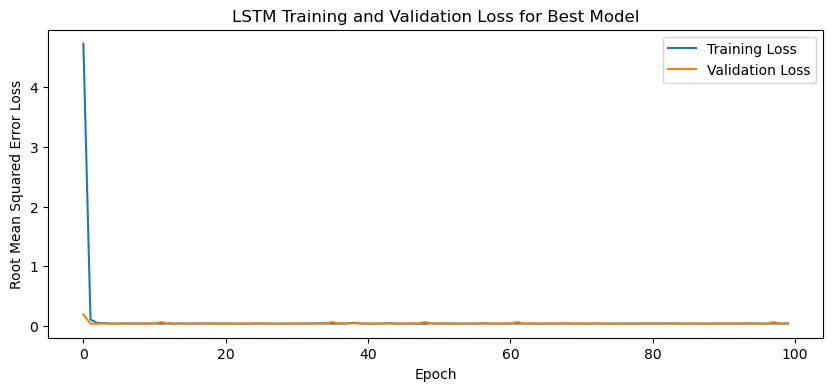

1/1 - 4s - loss: 0.0254 - 4s/epoch - 4s/step
Test Loss: 0.02543741650879383
1/1 [==============================] - 0s 106ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

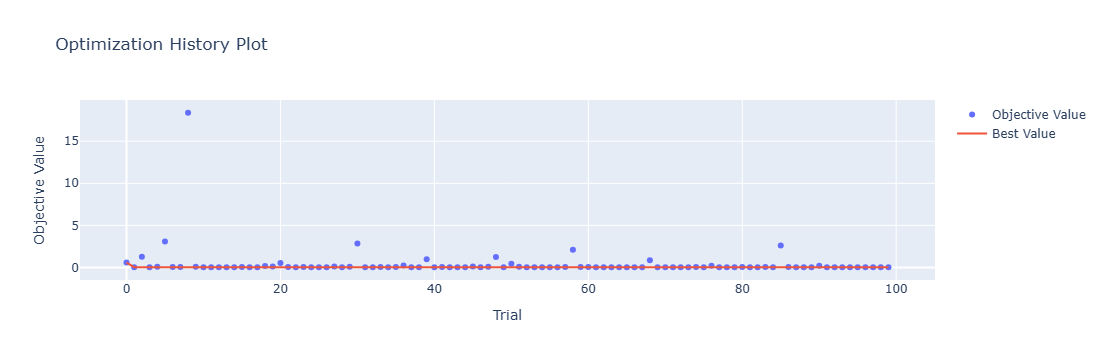

In [4]:
optuna.visualization.plot_optimization_history(study)

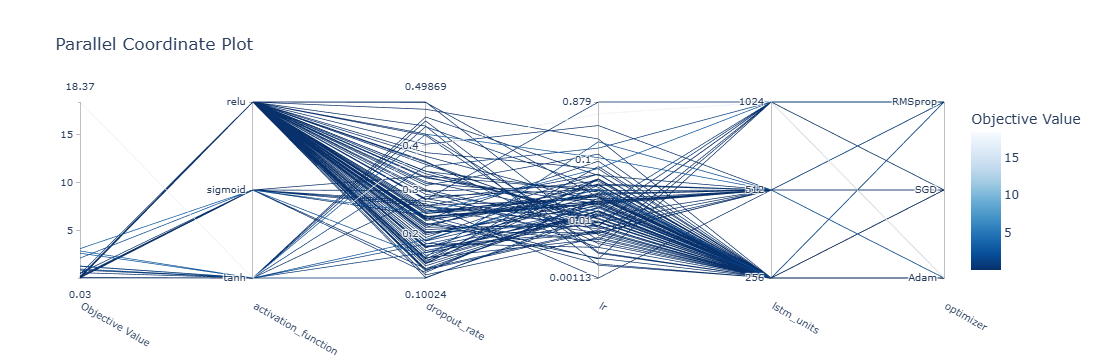

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

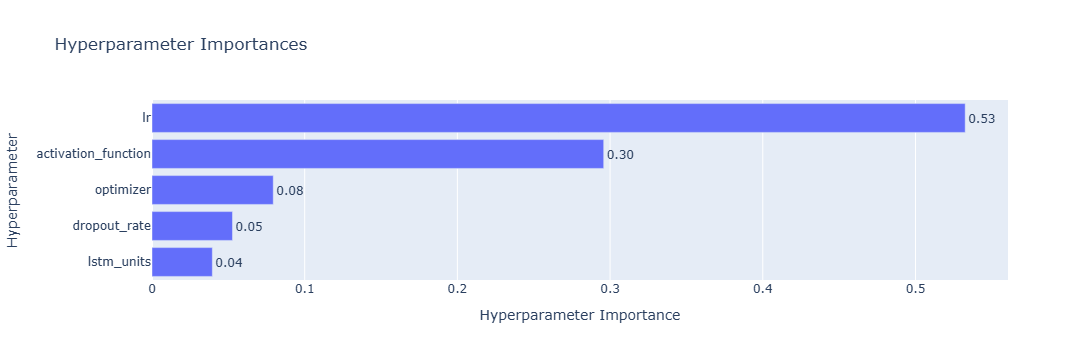

In [6]:
optuna.visualization.plot_param_importances(study)

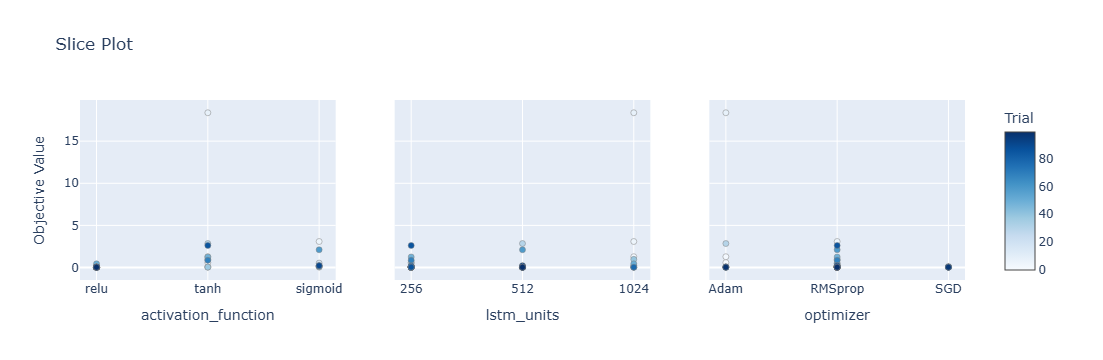

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

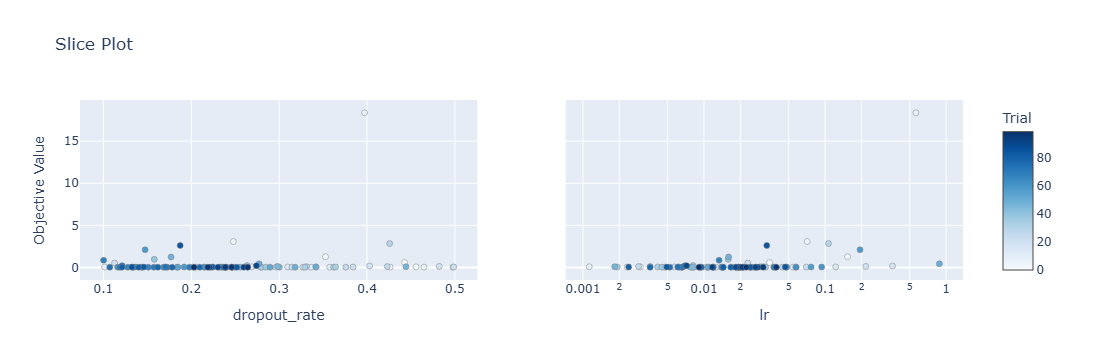

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.21  8.17 15.68 ... 23.86 20.59 15.82]
 [14.52 12.85 16.77 ... 26.49 23.17 21.15]
 [ 8.91  6.23 11.39 ... 22.62 16.72 14.05]
 ...
 [ 7.87  5.76 10.62 ... 21.07 15.24 12.04]
 [ 6.49  2.73  9.77 ... 21.93 16.5  11.44]
 [ 5.29  1.27  5.84 ... 22.11 15.37  9.87]]
Epoch 1/100
84/84 [==============================] - 41s 252ms/step - loss: 3.1973 - accuracy: 0.0000e+00 - mae: 3.1973 - rmse: 3.1973 - mape: 649.0349 - pearson: nan - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mae: 0.0344 - val_rmse: 0.0344 - val_mape: 7.3662 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 19s 228ms/step - loss: 0.0678 - accuracy: 0.0000e+00 - mae: 0.0678 - rmse: 0.0678 - mape: 14.4699 - pearson: nan - val_loss: 0.7208 - val_accuracy: 0.0000e+00 - val_mae: 0.7208 - val_rmse: 0.7208 - val_mape: 157.1881 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 17s 201ms/step - loss: 0.0569 - accuracy: 0.0000e+00 - mae: 0.0569 - rmse: 0.0569 - mape: 11.7958 - pearso

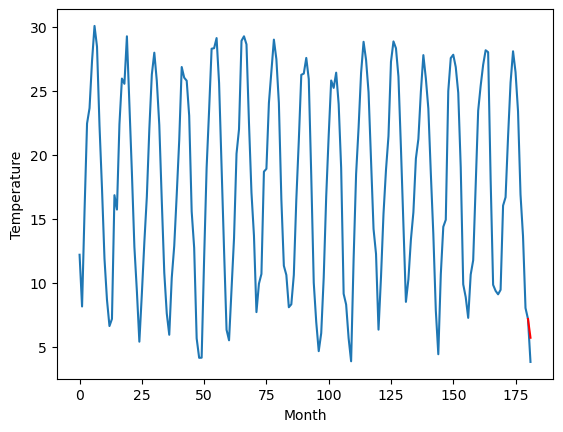

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.87		12.65		-0.22
[180, 181]
[13.23, 12.648874155282975]


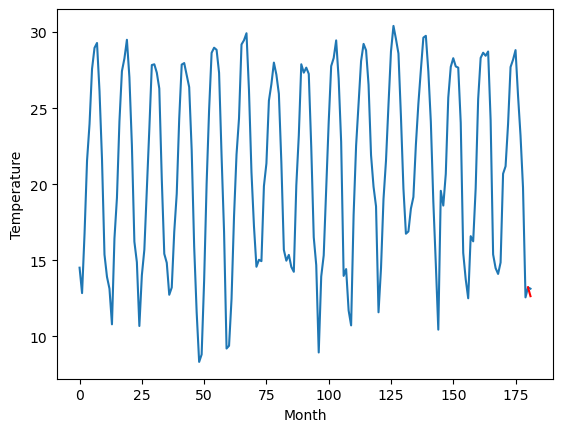

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.34		14.96		-0.38
[180, 181]
[7.18, 14.958874155282974]


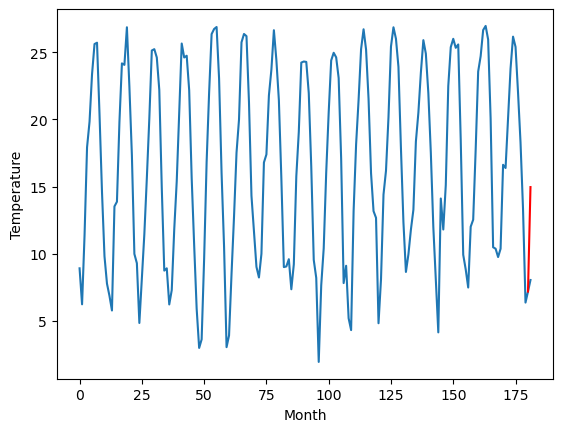

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.00		9.35		0.35
[180, 181]
[11.46, 9.348874155282974]


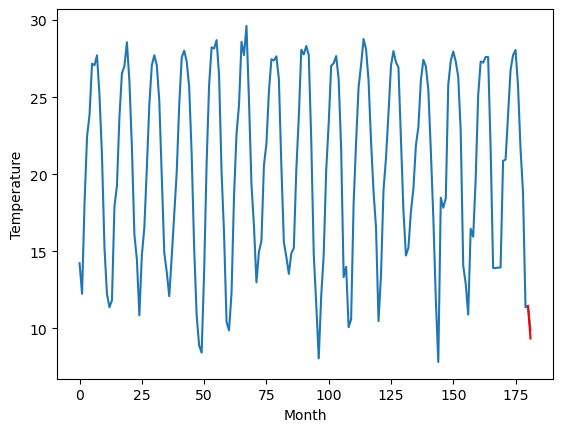

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		14.67		1.32
[180, 181]
[9.27, 14.668874155282975]


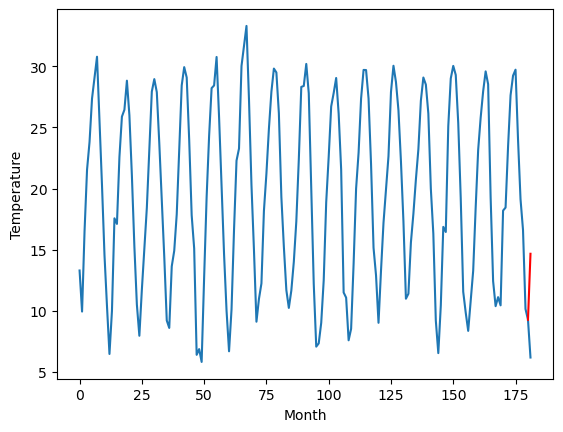

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.52		13.74		2.22
[180, 181]
[7.77, 13.738874155282975]


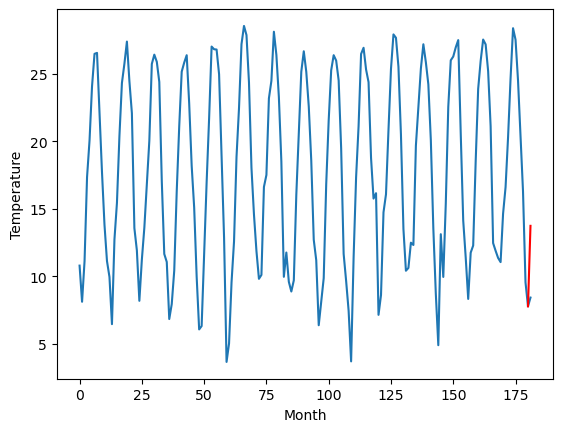

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.21		11.23		1.02
[180, 181]
[6.59, 11.228874155282973]


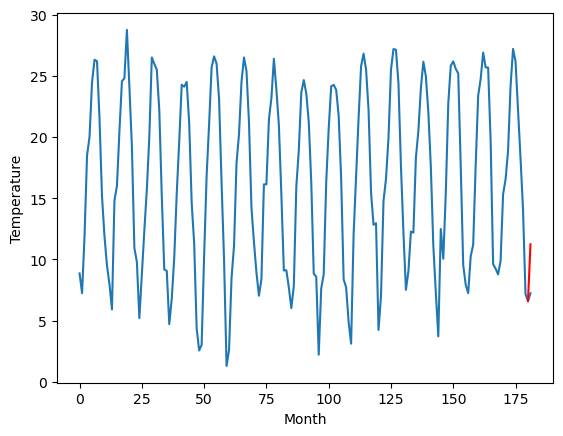

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.91		9.29		1.38
[180, 181]
[5.3, 9.288874155282974]


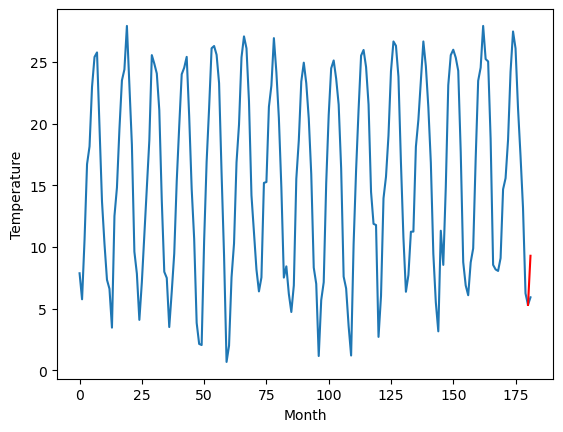

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.08		8.31		1.23
[180, 181]
[3.1, 8.308874155282975]


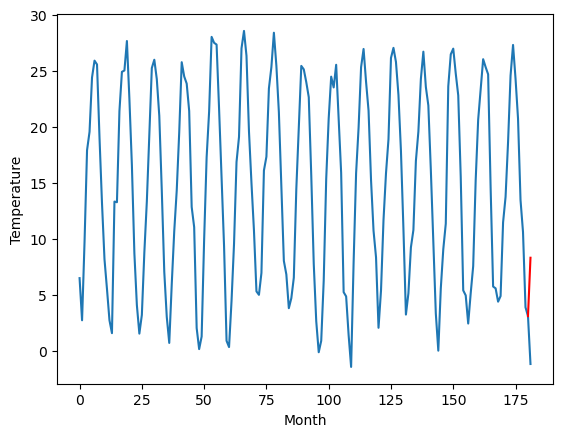

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.90		6.93		2.03
[180, 181]
[0.6, 6.9288741552829745]


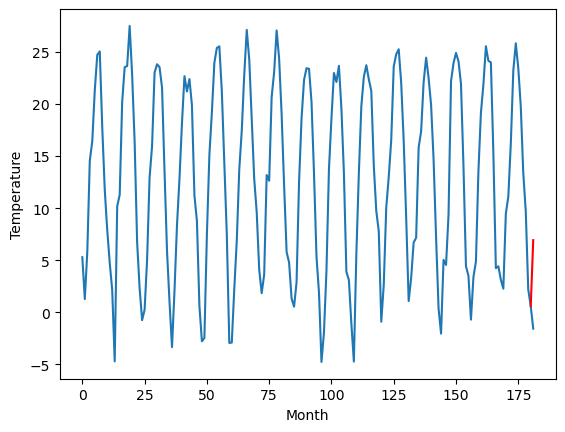

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.68		5.73		2.05
[180, 181]
[-0.75, 5.728874155282974]


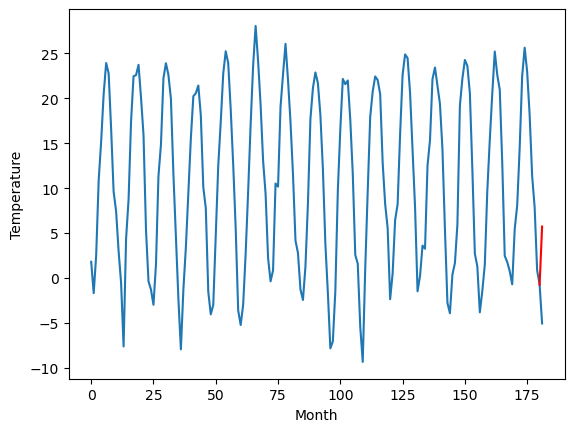

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.43   5.728874
1                 1   12.87  12.648874
2                 2   15.34  14.958874
3                 3    9.00   9.348874
4                 4   13.35  14.668874
5                 5   11.52  13.738874
6                 6   10.21  11.228874
7                 7    7.91   9.288874
8                 8    7.08   8.308874
9                 9    4.90   6.928874
10               10    3.68   5.728874


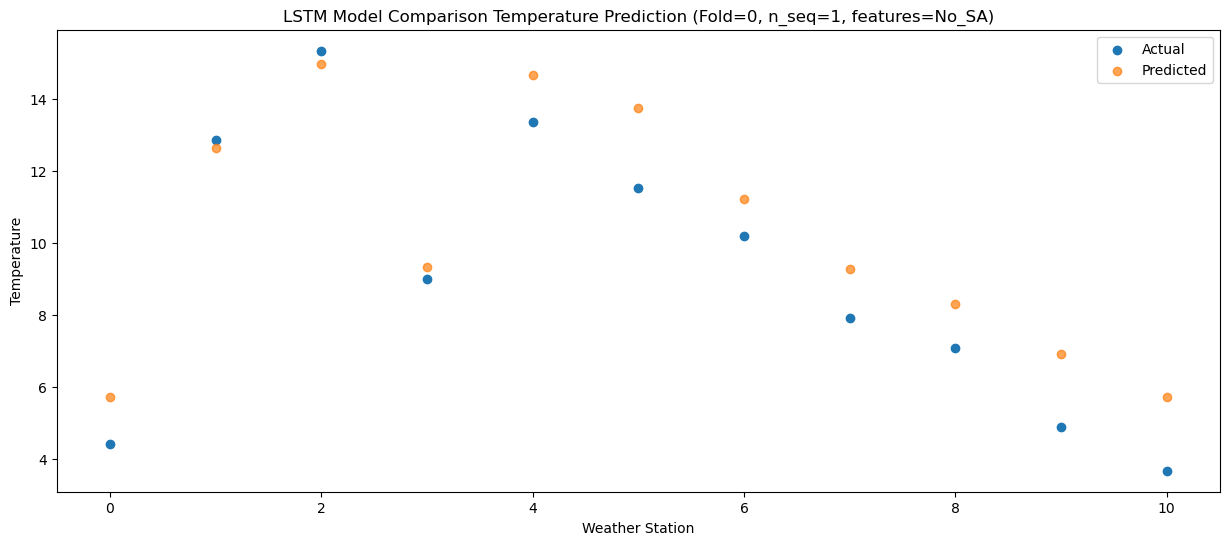

f, t:
[[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68]]
[[ 5.72887416 12.64887416 14.95887416  9.34887416 14.66887416 13.73887416
  11.22887416  9.28887416  8.30887416  6.92887416  5.72887416]]
Year at t+1:
t+1 SKRMSE: 1.395757
t+1 KRMSE: 1.395757
t+1 MAE: 1.226556
t+1 SKMAPE: 0.189445
t+1 R2_SCORE: 0.859598
t+1 KMAPE: 0.189445
t+1 PEARSON: 0.959594
t+1 AVERAGE ACTUAL: 9.117273
Metrics for this Fold:
SKRMSE: 1.395757
KRMSE: 1.395757
MAE: 1.226556
SKMAPE: 0.189445
R2_SCORE: 0.859598
KMAPE: 0.189445
PEARSON: 0.959594
AVERAGE ACTUAL: 9.117273
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 512)               5083136   
                                                                 
 dropout (Dropout)           (1, 1, 512)               0         
                                                                 
 lstm_1 (LSTM)    

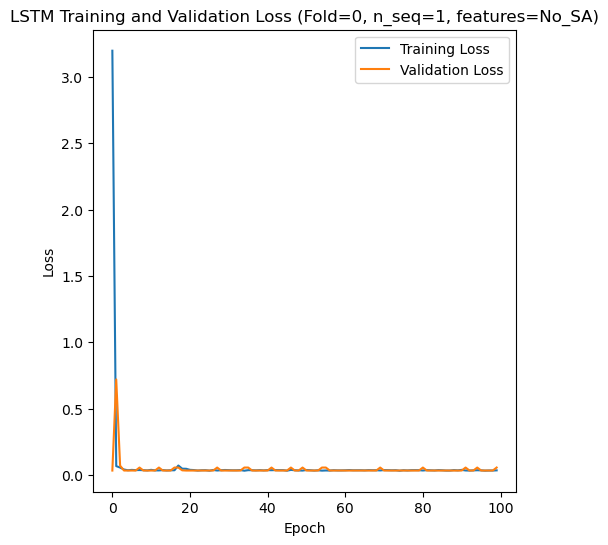

[[12.2  10.03 13.86 ... 24.46 19.58 17.03]
 [ 8.35  6.22 11.74 ... 22.47 18.02 13.98]
 [10.82  7.37 13.36 ... 24.57 19.57 16.15]
 ...
 [ 7.69  4.56 11.66 ... 25.3  19.83 13.28]
 [ 8.93  6.7  14.14 ... 25.37 21.51 12.55]
 [ 7.96  5.46 11.14 ... 25.13 20.28 10.63]]
Epoch 1/100
84/84 [==============================] - 40s 216ms/step - loss: 5.0540 - accuracy: 0.0000e+00 - mae: 5.0540 - rmse: 5.0540 - mape: 1183.3462 - pearson: nan - val_loss: 0.1179 - val_accuracy: 0.0000e+00 - val_mae: 0.1179 - val_rmse: 0.1179 - val_mape: 25.4602 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 14s 163ms/step - loss: 0.0669 - accuracy: 0.0000e+00 - mae: 0.0669 - rmse: 0.0669 - mape: 14.0954 - pearson: nan - val_loss: 0.0609 - val_accuracy: 0.0000e+00 - val_mae: 0.0609 - val_rmse: 0.0609 - val_mape: 12.6190 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 16s 185ms/step - loss: 0.0435 - accuracy: 0.0000e+00 - mae: 0.0435 - rmse: 0.0435 - mape: 9.0270 - pearso

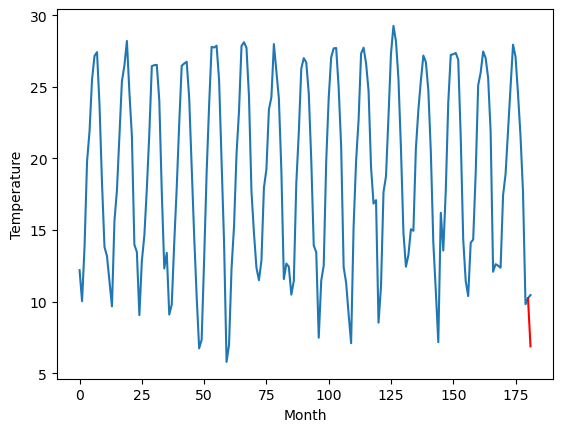

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.00		11.12		-0.88
[180, 181]
[6.41, 11.119063806533813]


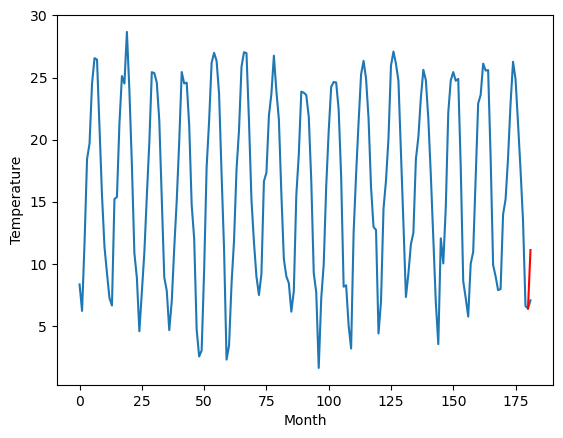

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.77		7.27		-1.50
[180, 181]
[7.6, 7.269063806533813]


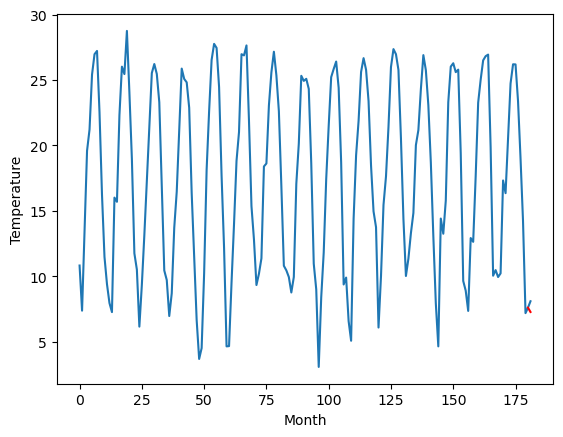

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.72		9.74		-0.98
[180, 181]
[11.89, 9.739063806533814]


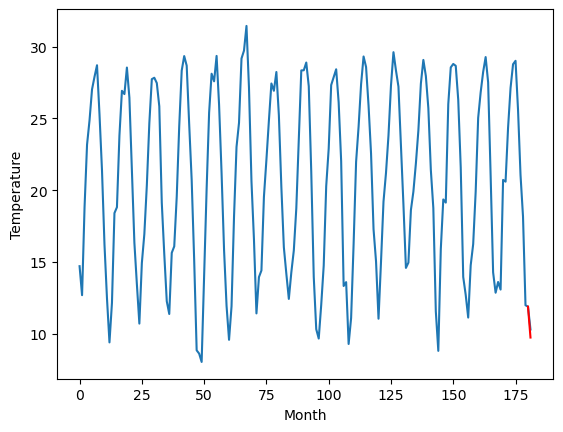

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.70		13.63		-1.07
[180, 181]
[10.96, 13.629063806533814]


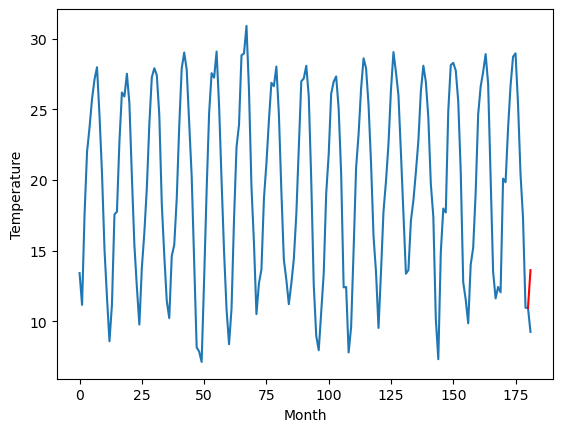

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.91		12.34		0.43
[180, 181]
[7.75, 12.339063806533813]


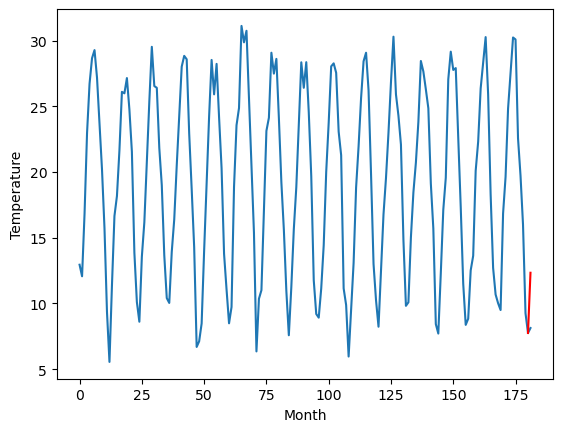

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.75		11.87		-0.88
[180, 181]
[6.17, 11.869063806533813]


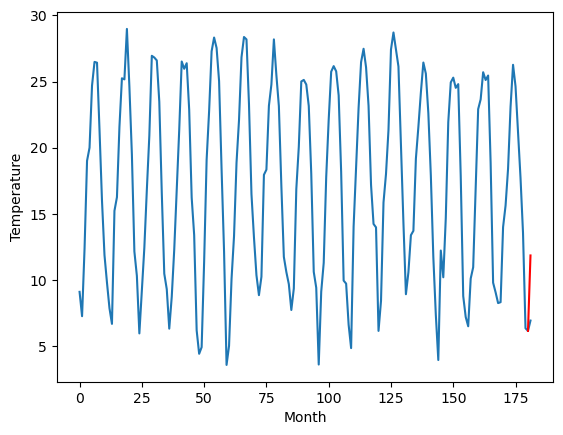

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.81		8.04		-0.77
[180, 181]
[4.57, 8.039063806533813]


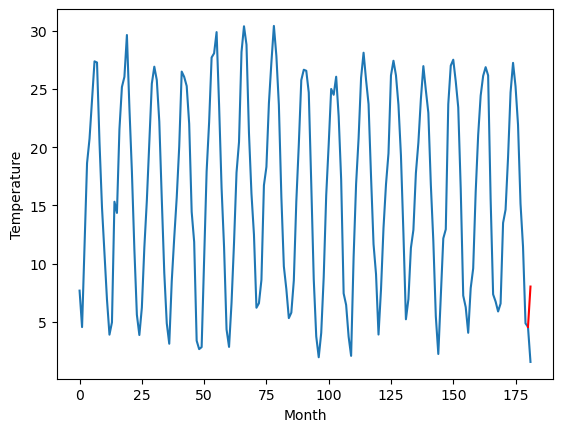

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.34		6.61		-0.73
[180, 181]
[5.46, 6.609063806533814]


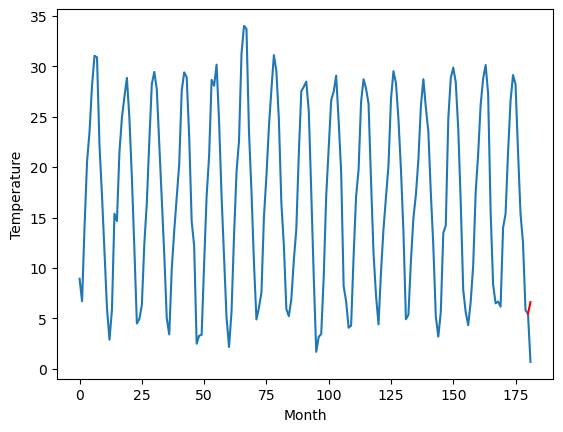

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.04		7.85		-1.19
[180, 181]
[5.42, 7.849063806533813]


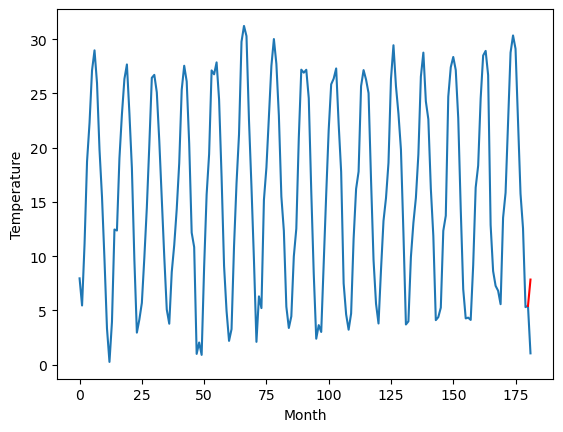

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.12		6.88		0.76
[180, 181]
[2.17, 6.879063806533813]


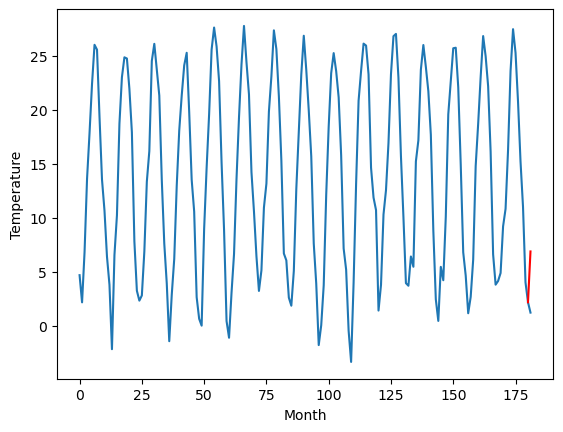

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.38   6.879064
1                 1   12.00  11.119064
2                 2    8.77   7.269064
3                 3   10.72   9.739064
4                 4   14.70  13.629064
5                 5   11.91  12.339064
6                 6   12.75  11.869064
7                 7    8.81   8.039064
8                 8    7.34   6.609064
9                 9    9.04   7.849064
10               10    6.12   6.879064


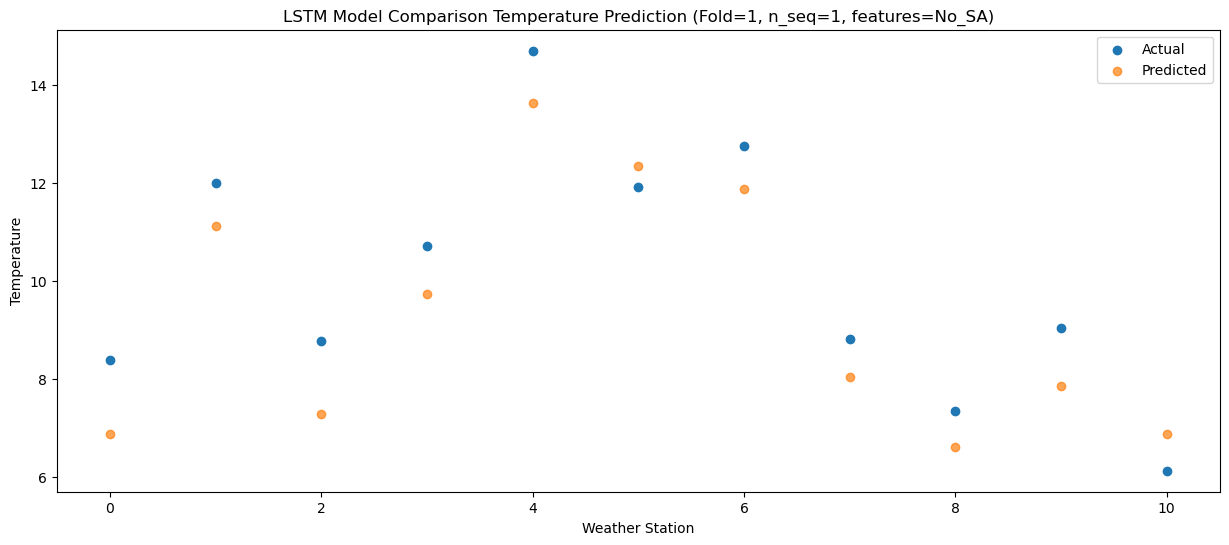

f, t:
[[ 8.38 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12]]
[[ 6.87906381 11.11906381  7.26906381  9.73906381 13.62906381 12.33906381
  11.86906381  8.03906381  6.60906381  7.84906381  6.87906381]]
Year at t+1:
t+1 SKRMSE: 1.021321
t+1 KRMSE: 1.021321
t+1 MAE: 0.972414
t+1 SKMAPE: 0.103273
t+1 R2_SCORE: 0.827191
t+1 KMAPE: 0.103273
t+1 PEARSON: 0.922746
t+1 AVERAGE ACTUAL: 10.049091
Metrics for this Fold:
SKRMSE: 1.021321
KRMSE: 1.021321
MAE: 0.972414
SKMAPE: 0.103273
R2_SCORE: 0.827191
KMAPE: 0.103273
PEARSON: 0.922746
AVERAGE ACTUAL: 10.049091
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_2 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_3 (LSTM)

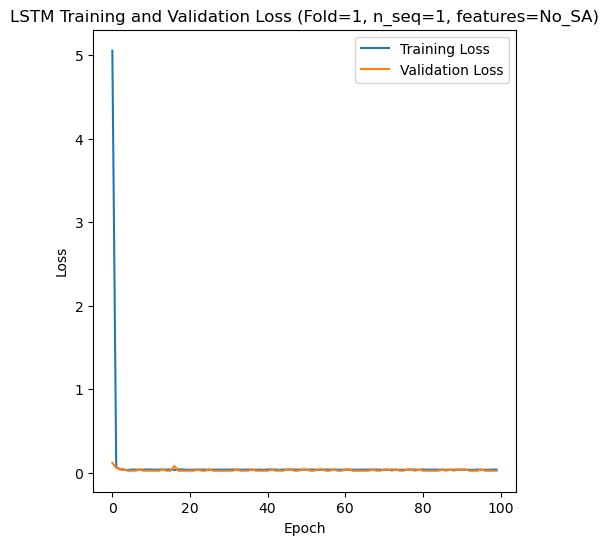

[[ 8.61  4.71 12.22 ... 22.49 18.22 13.52]
 [ 6.28  3.18  8.73 ... 22.36 17.39  7.52]
 [17.82 16.52 20.35 ... 28.79 25.32 22.93]
 ...
 [ 6.77  9.55 12.16 ... 24.55 20.29 10.24]
 [12.04 12.81 10.78 ... 23.32 20.33 13.93]
 [ 8.57  6.56 11.36 ... 21.36 16.14 12.65]]
Epoch 1/100
84/84 [==============================] - 59s 315ms/step - loss: 4.7584 - accuracy: 0.0000e+00 - mae: 4.7584 - rmse: 4.7584 - mape: 962.5520 - pearson: nan - val_loss: 0.0144 - val_accuracy: 0.0000e+00 - val_mae: 0.0144 - val_rmse: 0.0144 - val_mape: 3.2373 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 18s 216ms/step - loss: 0.0709 - accuracy: 0.0000e+00 - mae: 0.0709 - rmse: 0.0709 - mape: 14.8734 - pearson: nan - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - val_mae: 0.0156 - val_rmse: 0.0156 - val_mape: 3.4643 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 17s 204ms/step - loss: 0.0836 - accuracy: 0.0000e+00 - mae: 0.0836 - rmse: 0.0836 - mape: 17.2492 - pearson:

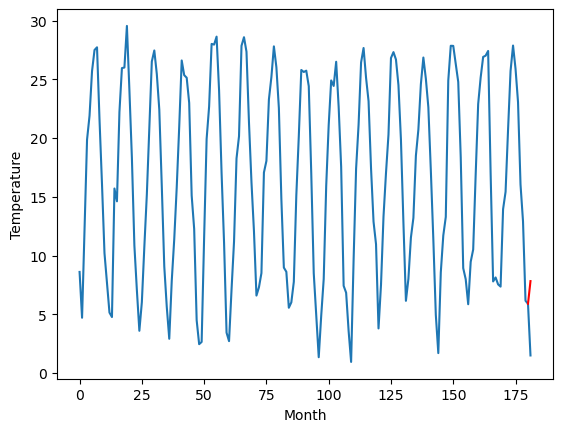

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		7.87		-0.66
[180, 181]
[2.63, 7.8689976191520685]


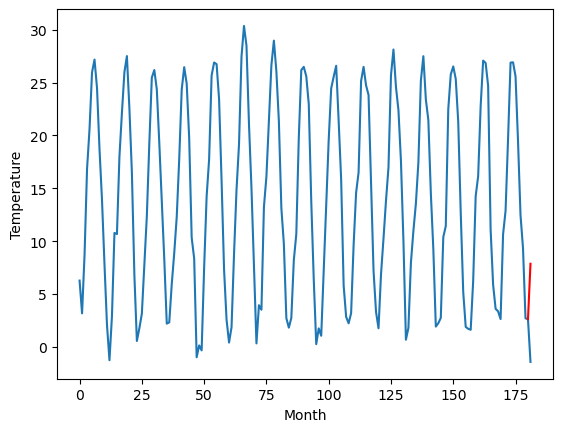

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.94		5.54		-1.40
[180, 181]
[16.55, 5.538997619152069]


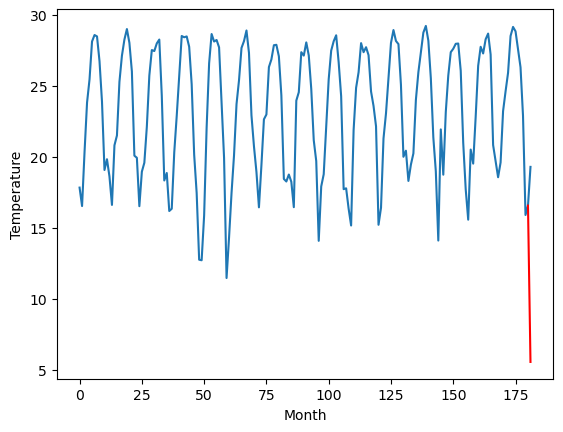

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.74		17.08		2.34
[180, 181]
[-0.83, 17.07899761915207]


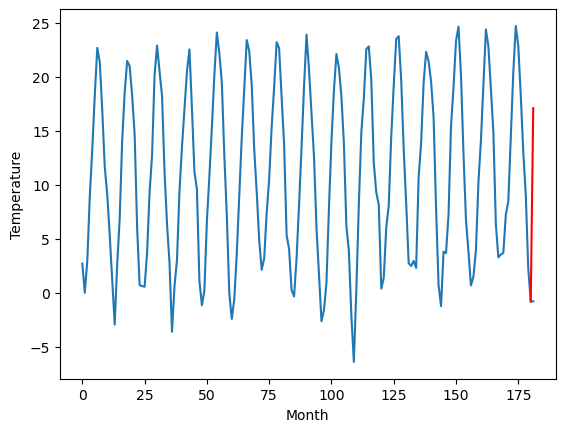

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.03		1.94		-1.09
[180, 181]
[11.52, 1.9389976191520693]


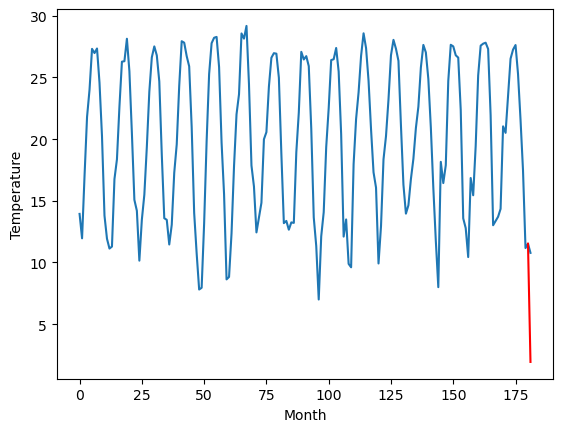

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.20		-0.15
[180, 181]
[11.47, 13.198997619152069]


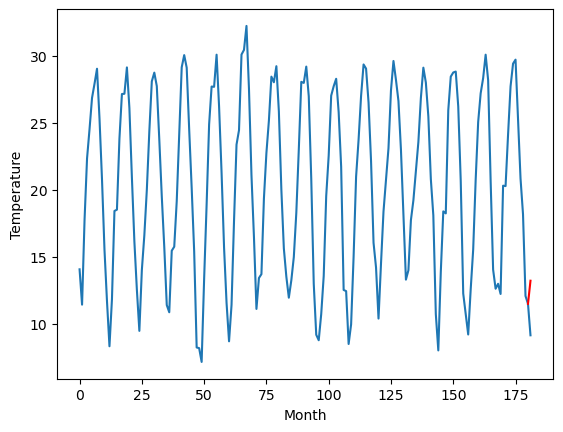

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.31		-0.04
[180, 181]
[7.75, 13.30899761915207]


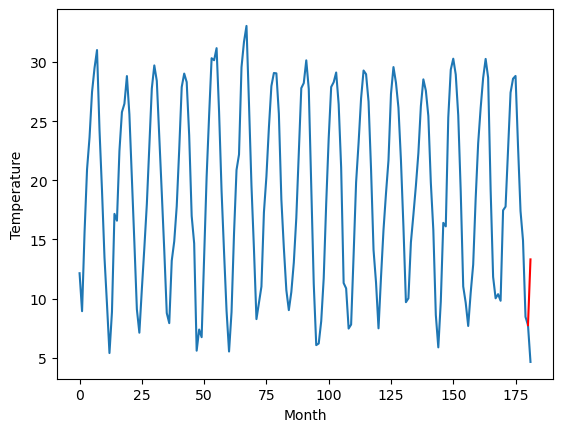

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.68		11.40		-1.28
[180, 181]
[4.9, 11.39899761915207]


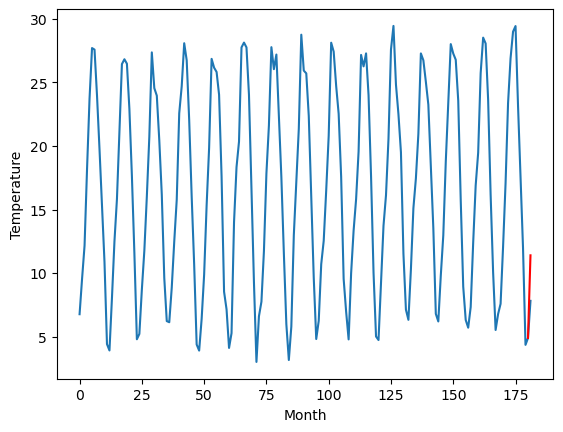

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.71		6.03		-0.68
[180, 181]
[14.14, 6.028997619152069]


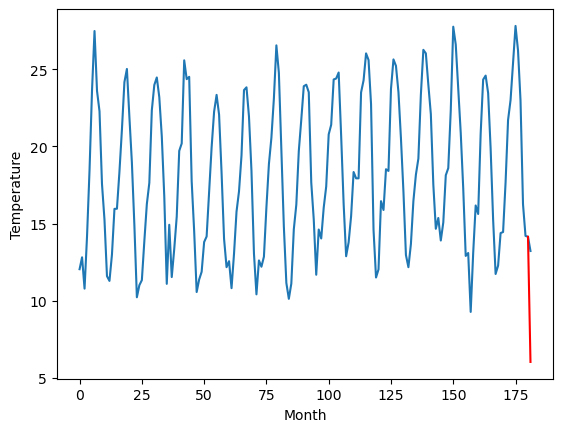

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.63		11.30		-0.33
[180, 181]
[5.55, 11.298997619152068]


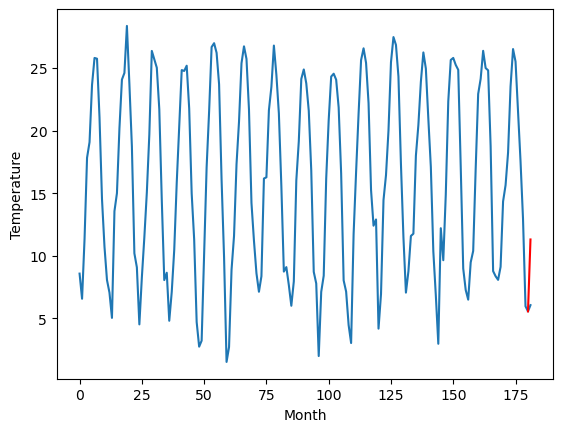

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.90		7.83		-1.07
[180, 181]
[3.19, 7.828997619152069]


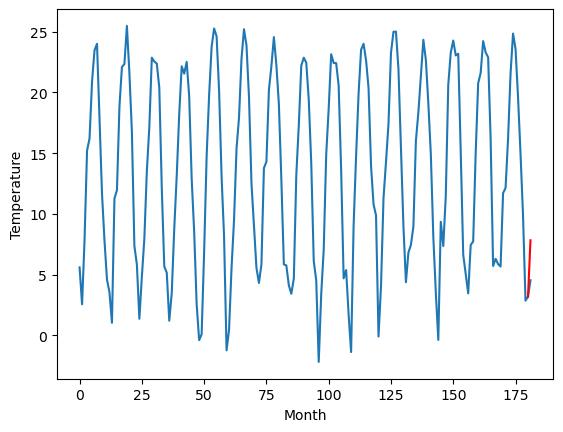

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.31   7.828998
1                 1    8.53   7.868998
2                 2    6.94   5.538998
3                 3   14.74  17.078998
4                 4    3.03   1.938998
5                 5   13.35  13.198998
6                 6   13.35  13.308998
7                 7   12.68  11.398998
8                 8    6.71   6.028998
9                 9   11.63  11.298998
10               10    8.90   7.828998


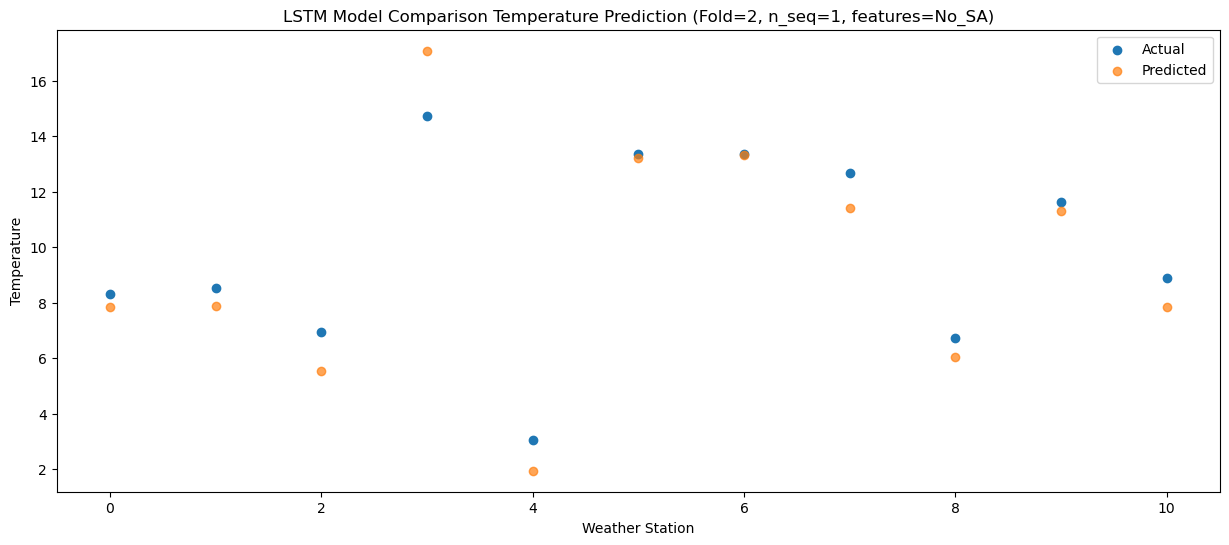

f, t:
[[ 8.31  8.53  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9 ]]
[[ 7.82899762  7.86899762  5.53899762 17.07899762  1.93899762 13.19899762
  13.30899762 11.39899762  6.02899762 11.29899762  7.82899762]]
Year at t+1:
t+1 SKRMSE: 1.073572
t+1 KRMSE: 1.073572
t+1 MAE: 0.866275
t+1 SKMAPE: 0.111063
t+1 R2_SCORE: 0.902056
t+1 KMAPE: 0.111063
t+1 PEARSON: 0.964758
t+1 AVERAGE ACTUAL: 9.833636
Metrics for this Fold:
SKRMSE: 1.073572
KRMSE: 1.073572
MAE: 0.866275
SKMAPE: 0.111063
R2_SCORE: 0.902056
KMAPE: 0.111063
PEARSON: 0.964758
AVERAGE ACTUAL: 9.833636
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_4 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_5 (LSTM)  

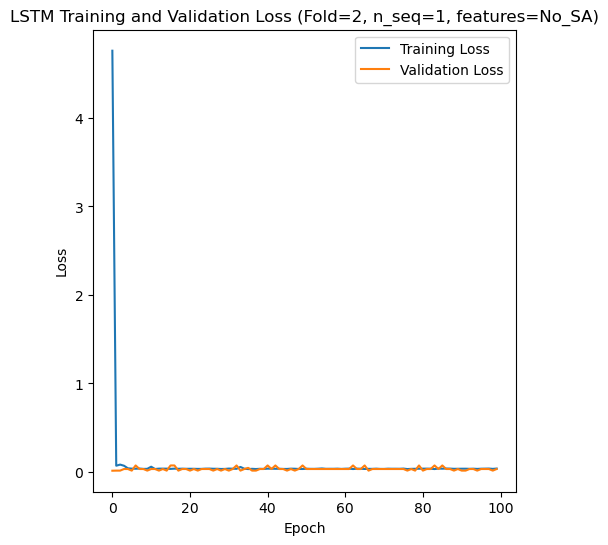

[[ 8.9   6.89 11.3  ... 22.19 16.88 13.54]
 [ 7.02  3.15 10.24 ... 22.31 18.92 11.32]
 [ 7.65  9.7   9.44 ... 25.68 20.65 11.46]
 ...
 [ 9.57 11.93 12.22 ... 30.9  25.01 12.37]
 [ 9.04  9.3   8.59 ... 17.72 17.26 10.73]
 [ 3.2   0.4   3.78 ... 18.92 14.39 10.04]]
Epoch 1/100
84/84 [==============================] - 59s 316ms/step - loss: 5.5317 - accuracy: 0.0000e+00 - mae: 5.5317 - rmse: 5.5317 - mape: 1307.3420 - pearson: nan - val_loss: 0.1265 - val_accuracy: 0.0000e+00 - val_mae: 0.1265 - val_rmse: 0.1265 - val_mape: 29.1512 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 18s 221ms/step - loss: 0.0539 - accuracy: 0.0000e+00 - mae: 0.0539 - rmse: 0.0539 - mape: 11.9099 - pearson: nan - val_loss: 0.0451 - val_accuracy: 0.0000e+00 - val_mae: 0.0451 - val_rmse: 0.0451 - val_mape: 8.9550 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 19s 223ms/step - loss: 0.0516 - accuracy: 0.0000e+00 - mae: 0.0516 - rmse: 0.0516 - mape: 11.6692 - pearso

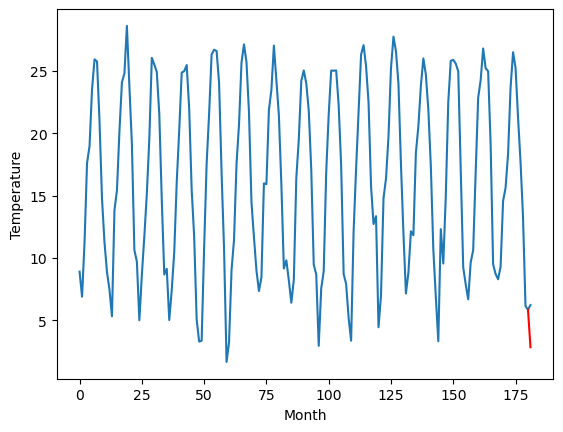

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.75		8.54		0.79
[180, 181]
[3.2, 8.535303378105164]


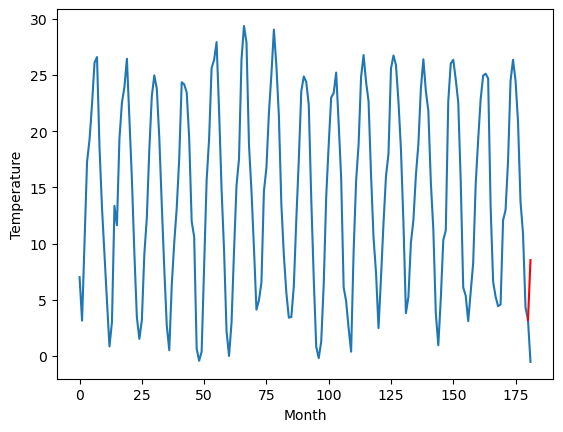

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.28		6.66		-1.62
[180, 181]
[8.48, 6.655303378105163]


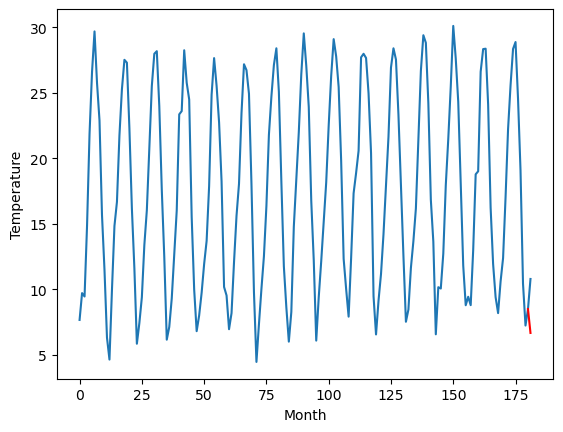

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.19		7.29		1.10
[180, 181]
[1.55, 7.285303378105164]


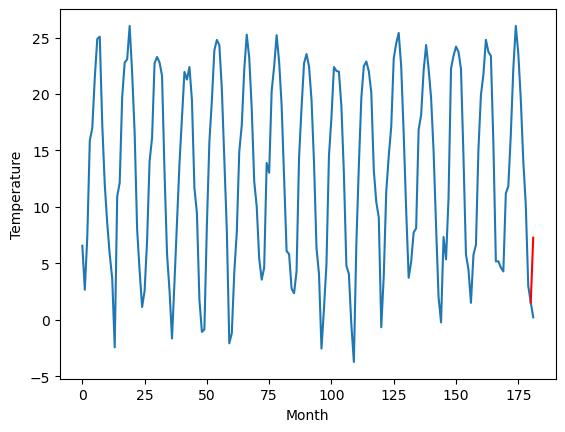

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.10		6.21		1.11
[180, 181]
[1.08, 6.205303378105164]


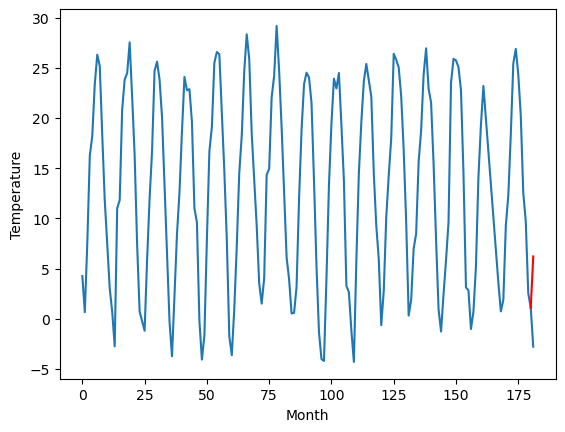

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.80		3.89		1.09
[180, 181]
[0.21, 3.8853033781051636]


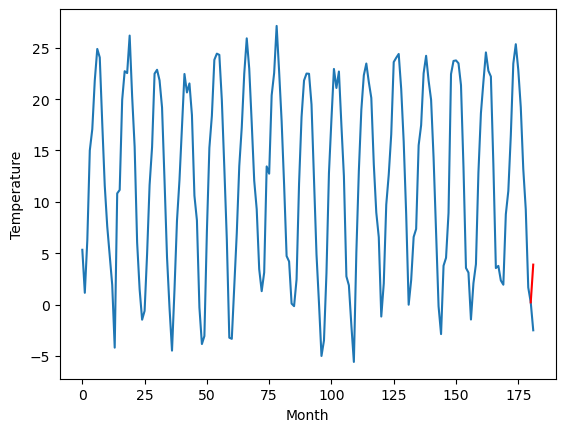

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.60		4.97		-0.63
[180, 181]
[-8.22, 4.965303378105164]


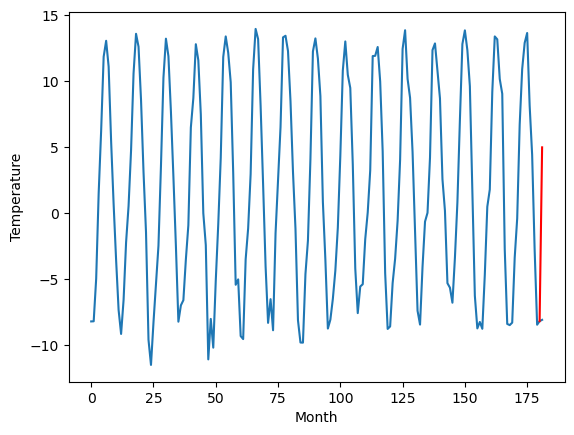

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-7.69		-8.60		-0.91
[180, 181]
[10.04, -8.604696621894837]


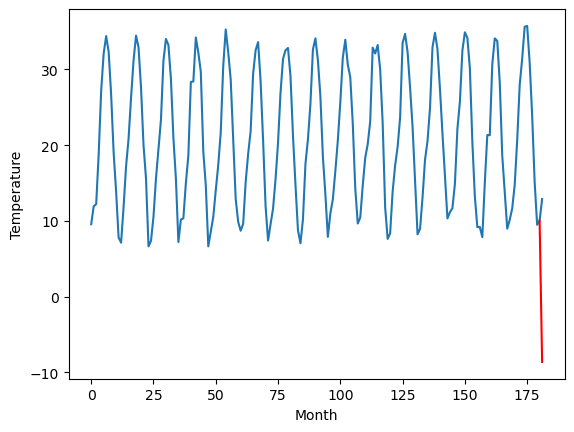

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		9.21		-1.58
[180, 181]
[9.17, 9.205303378105164]


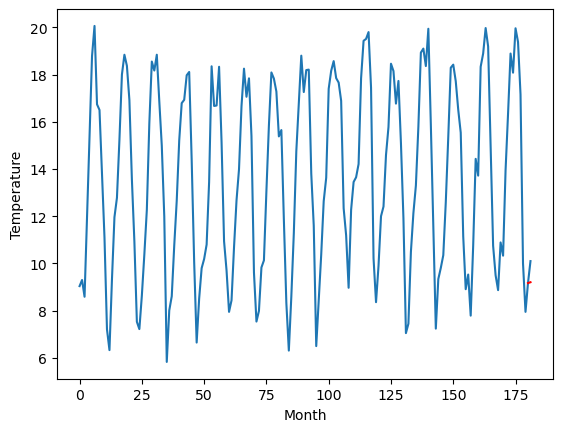

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.02		8.68		2.66
[180, 181]
[0.94, 8.675303378105163]


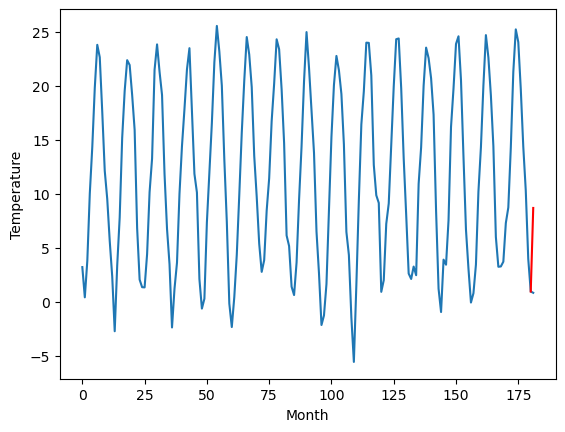

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.64		2.84		1.20
[180, 181]
[-0.13, 2.8353033781051638]


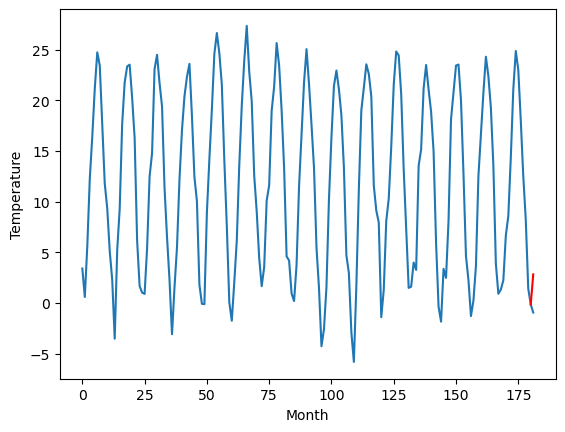

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.92   2.835303
1                 1    7.75   8.535303
2                 2    8.28   6.655303
3                 3    6.19   7.285303
4                 4    5.10   6.205303
5                 5    2.80   3.885303
6                 6    5.60   4.965303
7                 7   -7.69  -8.604697
8                 8   10.79   9.205303
9                 9    6.02   8.675303
10               10    1.64   2.835303


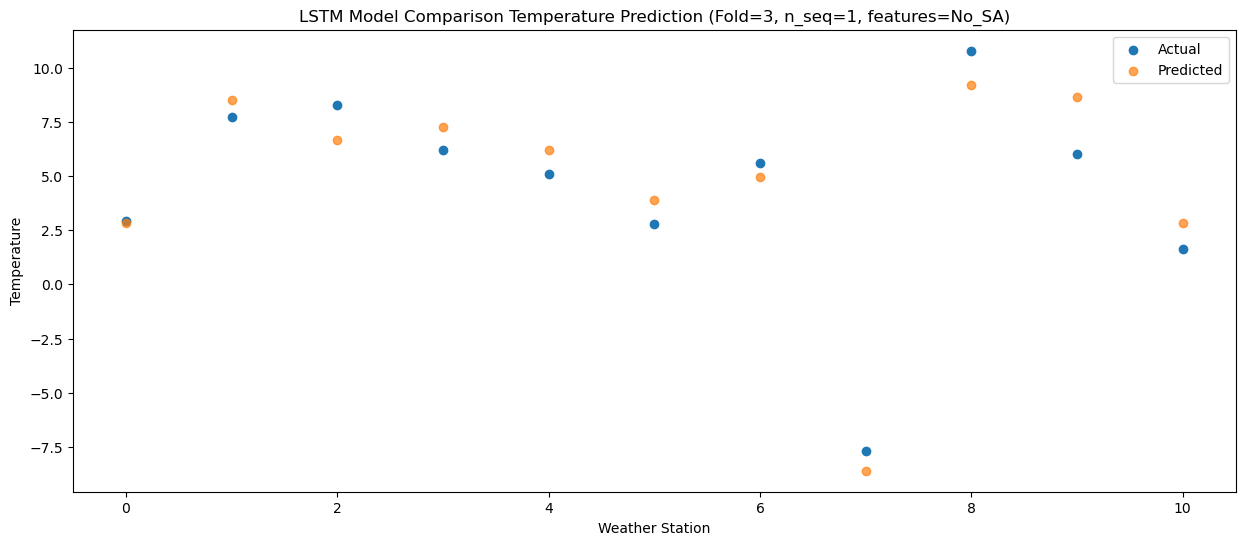

f, t:
[[ 2.92  7.75  8.28  6.19  5.1   2.8   5.6  -7.69 10.79  6.02  1.64]]
[[ 2.83530338  8.53530338  6.65530338  7.28530338  6.20530338  3.88530338
   4.96530338 -8.60469662  9.20530338  8.67530338  2.83530338]]
Year at t+1:
t+1 SKRMSE: 1.317468
t+1 KRMSE: 1.317468
t+1 MAE: 1.160482
t+1 SKMAPE: 0.241537
t+1 R2_SCORE: 0.918166
t+1 KMAPE: 0.219911
t+1 PEARSON: 0.926602
t+1 AVERAGE ACTUAL: 4.490909
Metrics for this Fold:
SKRMSE: 1.317468
KRMSE: 1.317468
MAE: 1.160482
SKMAPE: 0.241537
R2_SCORE: 0.918166
KMAPE: 0.219911
PEARSON: 0.926602
AVERAGE ACTUAL: 4.490909
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_6 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_7 (LSTM)  

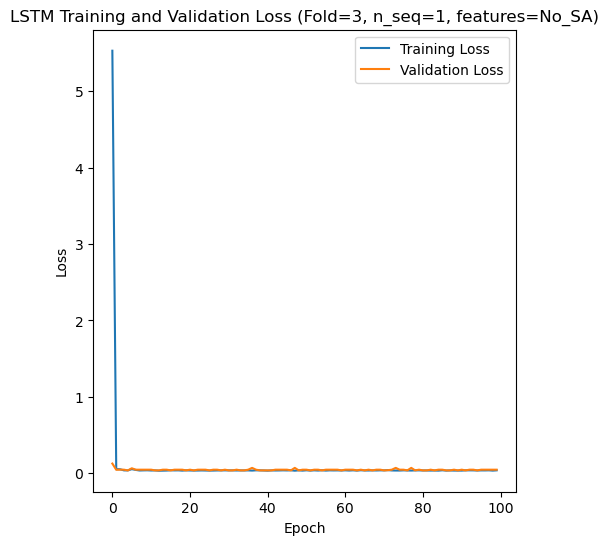

[[ 4.89  1.26  7.78 ... 22.59 18.46  9.82]
 [15.38 13.87 17.63 ... 26.66 22.89 20.2 ]
 [11.49  8.39 14.48 ... 24.97 20.83 17.82]
 ...
 [ 7.64  3.61 10.44 ... 21.3  17.62 11.34]
 [ 4.26  0.29  5.21 ... 21.47 15.54  9.34]
 [ 3.62 -0.32  6.05 ... 19.99 14.92  8.29]]
Epoch 1/100
84/84 [==============================] - 60s 319ms/step - loss: 3.5290 - accuracy: 0.0000e+00 - mae: 3.5290 - rmse: 3.5290 - mape: 787.7141 - pearson: nan - val_loss: 0.0681 - val_accuracy: 0.0000e+00 - val_mae: 0.0681 - val_rmse: 0.0681 - val_mape: 15.9503 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 19s 224ms/step - loss: 0.0650 - accuracy: 0.0000e+00 - mae: 0.0650 - rmse: 0.0650 - mape: 13.7099 - pearson: nan - val_loss: 0.0535 - val_accuracy: 0.0000e+00 - val_mae: 0.0535 - val_rmse: 0.0535 - val_mape: 11.0760 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 19s 220ms/step - loss: 0.0463 - accuracy: 0.0000e+00 - mae: 0.0463 - rmse: 0.0463 - mape: 9.7166 - pearson

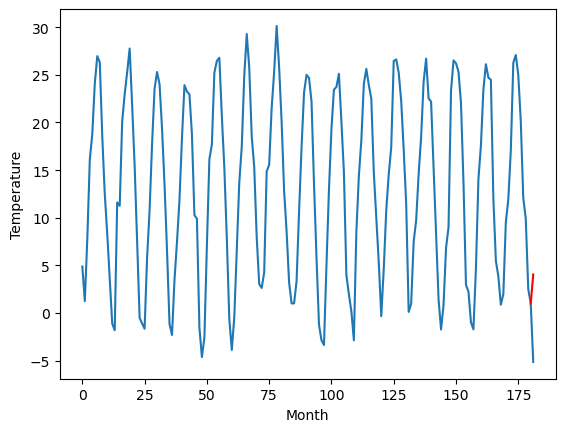

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.59		5.32		-0.27
[180, 181]
[14.25, 5.323817595243454]


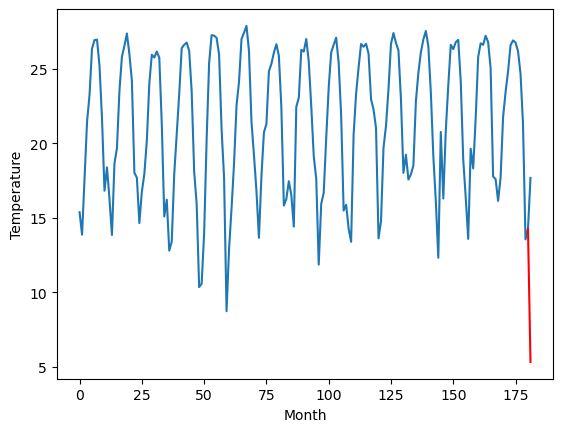

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.41		15.81		0.40
[180, 181]
[9.06, 15.813817595243455]


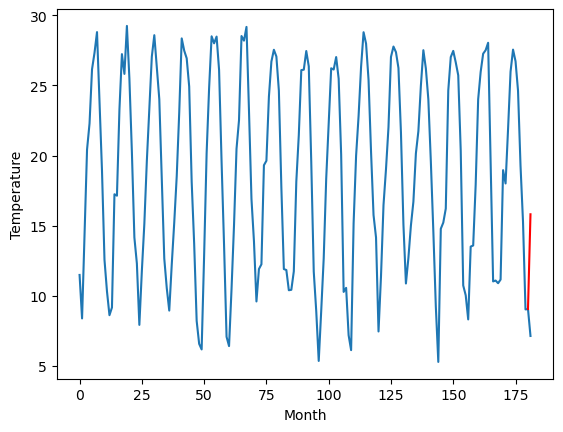

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.57		11.92		1.35
[180, 181]
[7.48, 11.923817595243454]


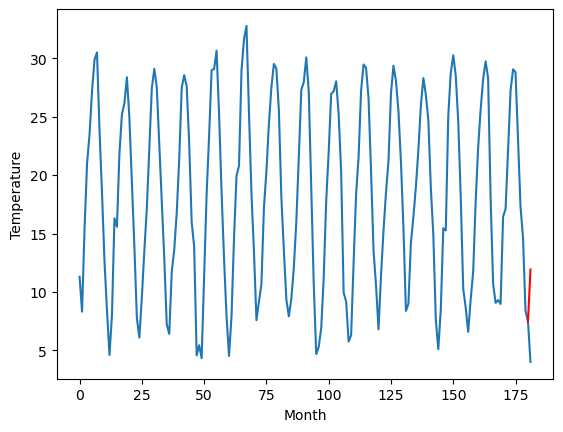

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.71		11.74		1.03
[180, 181]
[7.33, 11.743817595243454]


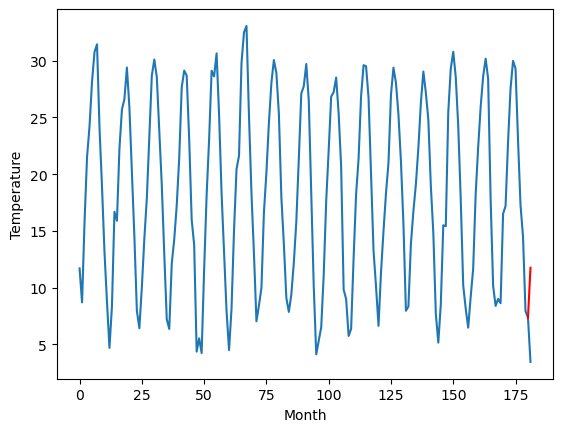

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.59		12.12		1.53
[180, 181]
[6.59, 12.123817595243453]


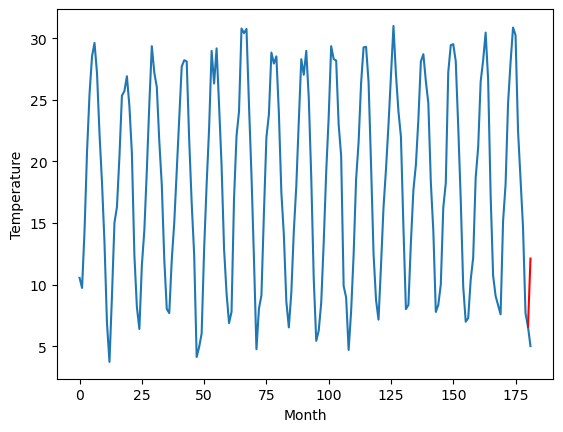

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		10.99		0.20
[180, 181]
[6.04, 10.993817595243454]


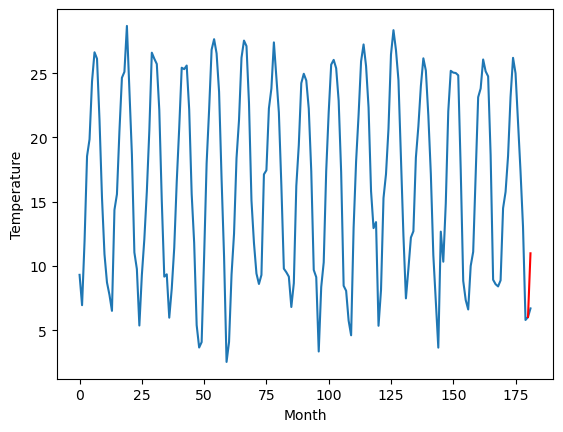

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.65		9.75		2.10
[180, 181]
[3.13, 9.753817595243454]


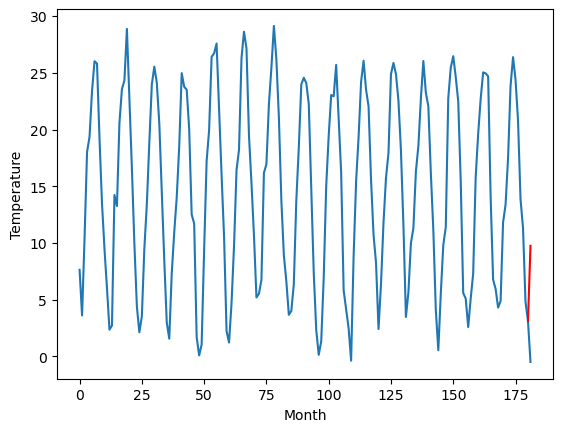

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.06		8.07		2.01
[180, 181]
[-0.29, 8.073817595243455]


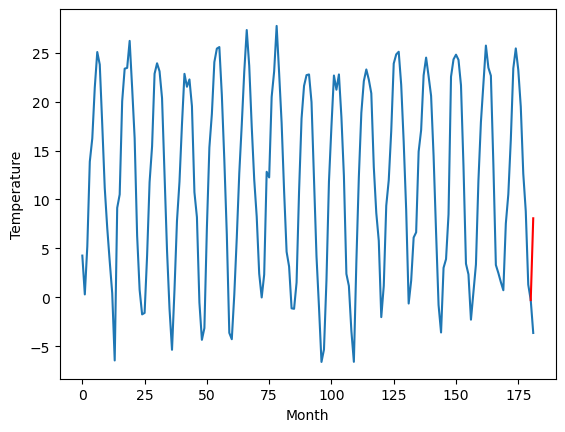

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.23		4.69		2.46
[180, 181]
[-1.03, 4.693817595243454]


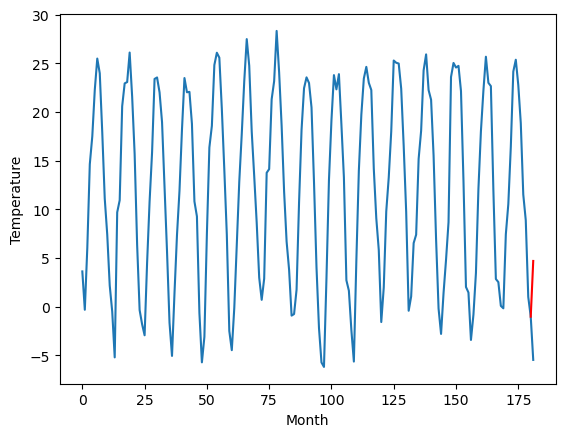

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.70		4.05		2.35
[180, 181]
[-2.29, 4.053817595243454]


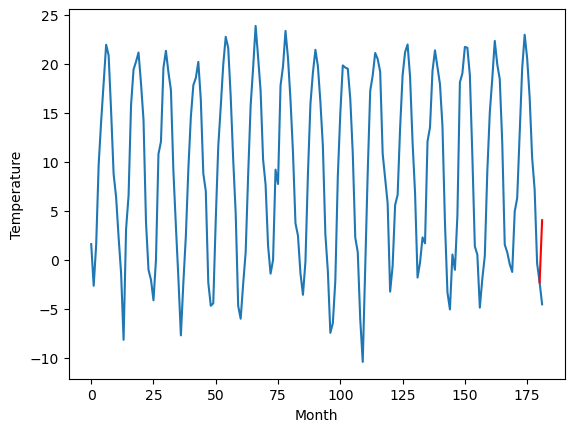

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.11   4.053818
1                 1    5.59   5.323818
2                 2   15.41  15.813818
3                 3   10.57  11.923818
4                 4   10.71  11.743818
5                 5   10.59  12.123818
6                 6   10.79  10.993818
7                 7    7.65   9.753818
8                 8    6.06   8.073818
9                 9    2.23   4.693818
10               10    1.70   4.053818


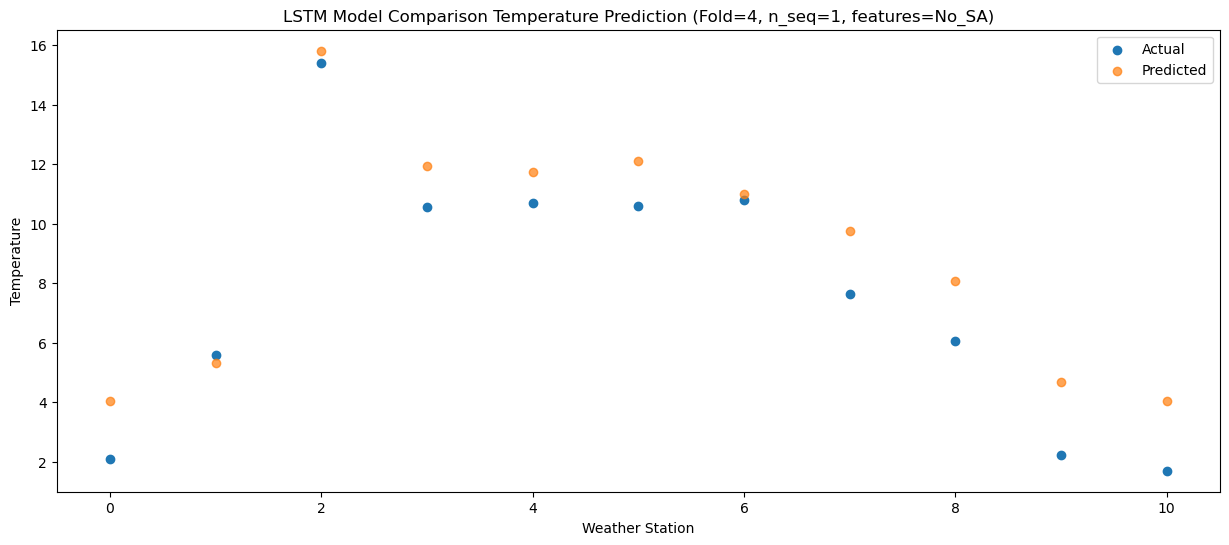

f, t:
[[ 2.11  5.59 15.41 10.57 10.71 10.59 10.79  7.65  6.06  2.23  1.7 ]]
[[ 4.0538176  5.3238176 15.8138176 11.9238176 11.7438176 12.1238176
  10.9938176  9.7538176  8.0738176  4.6938176  4.0538176]]
Year at t+1:
t+1 SKRMSE: 1.634860
t+1 KRMSE: 1.634860
t+1 MAE: 1.424942
t+1 SKMAPE: 0.407288
t+1 R2_SCORE: 0.852113
t+1 KMAPE: 0.407288
t+1 PEARSON: 0.964881
t+1 AVERAGE ACTUAL: 7.582727
Metrics for this Fold:
SKRMSE: 1.634860
KRMSE: 1.634860
MAE: 1.424942
SKMAPE: 0.407288
R2_SCORE: 0.852113
KMAPE: 0.407288
PEARSON: 0.964881
AVERAGE ACTUAL: 7.582727
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_8 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_9 (LSTM)             

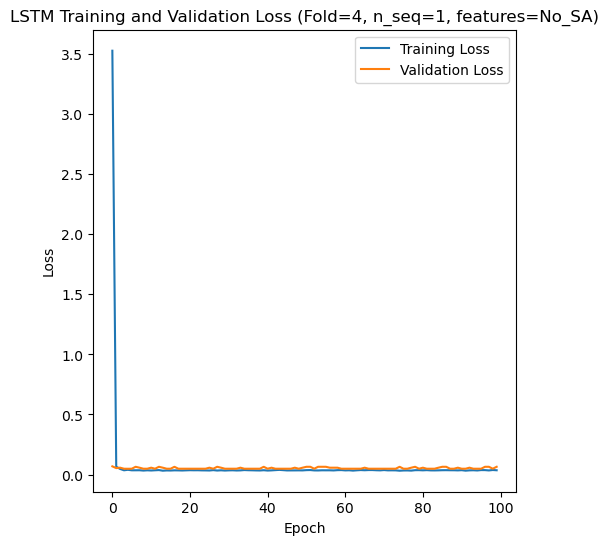

[[1.3957571474993506], [1.0213213000123587], [1.0735715286771865], [1.3174680188551682], [1.6348603412891318]]
[[array(1.39575715)], [array(1.0213213)], [array(1.07357153)], [array(1.31746802)], [array(1.63486034)]]
[[1.22655628063462], [0.9724139412966637], [0.8662746752392166], [1.1604821252822874], [1.424941668835553]]
[[0.1894445426587522], [0.10327290385783491], [0.1110631607581639], [0.24153747252652202], [0.4072881691584547]]
[[0.859598272882185], [0.8271912233527292], [0.9020564359859339], [0.9181658669600308], [0.8521127979737653]]
[[array(0.18944454)], [array(0.1032729)], [array(0.11106316)], [array(0.21991088)], [array(0.40728817)]]
[[array(0.95959443)], [array(0.92274572)], [array(0.96475756)], [array(0.92660192)], [array(0.96488054)]]
[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68  8.38
 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12  8.31  8.53
  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9   2.92  7.75  8.28
  6.19  5.1   2.8   5.6

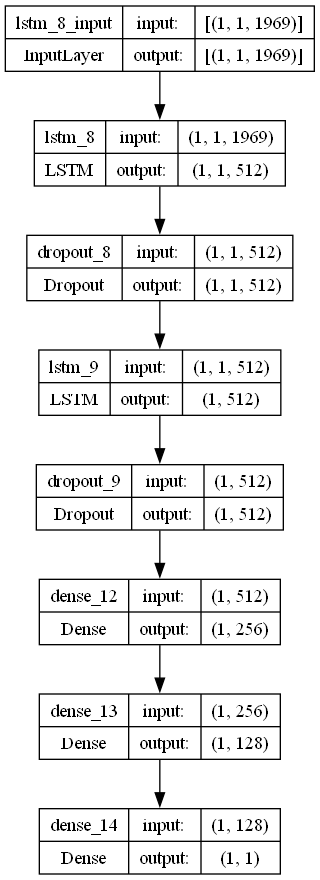

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr =  0.020125309703437972
    optimizer = RMSprop(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.2462968889061536

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)